# Generate the Channel Models

In [ ]:
import numpy as np
import h5py
from copy import deepcopy
from scipy.stats import norm
from scipy.optimize import fmin_l_bfgs_b
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF, Matern, RationalQuadratic, ConstantKernel as C
)
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)
np.random.seed(42)

# ----------------------------
# Optimizer wrapper (must return (theta_opt, func_min))
# ----------------------------
def custom_optimizer(obj_func, initial_theta, bounds):
    theta_opt, func_min, _ = fmin_l_bfgs_b(
        obj_func, initial_theta, bounds=bounds, maxiter=2000
    )
    return theta_opt, func_min

# ----------------------------
# Array responses & covariances
# ----------------------------
def planar_array_response(Y, Z, phi, theta, kd):
    m = np.arange(Y)
    n = np.arange(Z)
    phase_y = kd * m * np.sin(phi) * np.sin(theta)
    phase_z = kd * n * np.cos(theta)
    phase = np.outer(phase_y, np.ones(Z)) + np.outer(np.ones(Y), phase_z)
    a = np.exp(1j * phase).reshape(-1)
    return a / np.linalg.norm(a)

def generate_correlation_matrix(array_dims, phi_mean, theta_mean, sigma_phi, kd, num_samples=1000):
    Y, Z = array_dims
    R = np.zeros((Y*Z, Y*Z), dtype=np.complex128)
    for _ in range(num_samples):
        phi = phi_mean + norm.rvs(scale=sigma_phi)
        theta = theta_mean + norm.rvs(scale=sigma_phi)
        a = planar_array_response(Y, Z, phi, theta, kd)
        R += np.outer(a, a.conj())
    R /= num_samples
    return R

# ----------------------------
# Channel models
# ----------------------------
def generate_kronecker_mimo_channel(**params):
    Yt, Zt = params["tx_array_dims"]; Yr, Zr = params["rx_array_dims"]
    Nt, Nr = Yt * Zt, Yr * Zr

    dx, dy, dz = np.array(params["rx_pos"]) - np.array(params["tx_pos"])
    d_2d = np.sqrt(dx**2 + dy**2)
    phi_los_tx   = np.arctan2(dy, dx)
    theta_los_tx = np.arctan2(dz, d_2d)

    c = 3e8
    lambda_c = c / params["fc"]
    kd = (2*np.pi / lambda_c) * (lambda_c/2)  # π for half-wavelength

    R_tx = generate_correlation_matrix(params["tx_array_dims"],  phi_los_tx,  theta_los_tx,
                                       params["sigma_phi"], kd, params.get("num_samples", 1000))
    R_rx = generate_correlation_matrix(params["rx_array_dims"], -phi_los_tx, -theta_los_tx,
                                       params["sigma_phi"], kd, params.get("num_samples", 1000))

    G = (np.random.randn(Nr, Nt) + 1j*np.random.randn(Nr, Nt)) / np.sqrt(2)
    L_rx = np.linalg.cholesky(R_rx + 1e-12*np.eye(Nr))
    L_tx = np.linalg.cholesky(R_tx + 1e-12*np.eye(Nt))
    H = L_rx @ G @ L_tx.conj().T

    return H.astype(np.complex128)

def _sinkhorn_to_marginals(M, row_sums, col_sums, iters=200, eps=1e-12):
    r = np.ones_like(row_sums, dtype=np.float64)
    c = np.ones_like(col_sums, dtype=np.float64)
    for _ in range(iters):
        Mr = M * r[:, None]; c = col_sums / (Mr.sum(axis=0) + eps)
        Mc = M * r[:, None] * c[None, :]; r = row_sums / (Mc.sum(axis=1) + eps)
    return M * r[:, None] * c[None, :]

def generate_weichselberger_mimo_channel(**params):
    Yt, Zt = params["tx_array_dims"]; Yr, Zr = params["rx_array_dims"]
    Nt, Nr = Yt * Zt, Yr * Zr

    # Estimate side covariances from a few Kronecker draws
    R_rx = np.zeros((Nr, Nr), dtype=np.complex128)
    R_tx = np.zeros((Nt, Nt), dtype=np.complex128)
    num = params.get("num_avg_kron", 100)
    for _ in range(num):
        Hk = generate_kronecker_mimo_channel(**params)
        R_rx += Hk @ Hk.conj().T
        R_tx += Hk.conj().T @ Hk
    R_rx /= num; R_tx /= num

    S_rx, U_rx = np.linalg.eigh(R_rx)
    S_tx, U_tx = np.linalg.eigh(R_tx)
    S_rx = np.clip(S_rx.real, 0.0, None)
    S_tx = np.clip(S_tx.real, 0.0, None)

    Omega0 = np.outer(S_rx, S_tx) + 1e-16
    Omega  = _sinkhorn_to_marginals(Omega0, S_rx, S_tx)

    G = (np.random.randn(Nr, Nt) + 1j*np.random.randn(Nr, Nt)) / np.sqrt(2)
    H = U_rx @ (np.sqrt(Omega) * G) @ U_tx.conj().T
    return H.astype(np.complex128)

# ----------------------------
# Cases (36×36)
# ----------------------------
def indices_for_case(case, Nr, Nt):
    if case == "Case I":
        return [(r, 0) for r in range(Nr)]
    elif case == "Case II":
        return [(r, t) for t in range(0, Nt, 2) for r in range(Nr)]
    elif case == "Case III":
        d = min(Nr, Nt)
        return [(i, i) for i in range(d)]
    else:
        raise ValueError(f"Unknown case: {case}")

# ----------------------------
# 2D inputs for generic kernels (normalized [0,1])
# ----------------------------
def coords_2d_from_indices(pairs, Nr, Nt):
    pairs = np.asarray(pairs, dtype=int)
    r = pairs[:, 0].astype(np.float64) / max(Nr - 1, 1)
    t = pairs[:, 1].astype(np.float64) / max(Nt - 1, 1)
    return np.column_stack([r, t])

# Column-major enumeration for consistent reshape(order='F')
def all_rt_pairs_colmajor(Nr, Nt):
    return [(r, t) for t in range(Nt) for r in range(Nr)]

# ----------------------------
# GP helpers
# ----------------------------
def fit_predict_shared_kernel(Xtr, ytr_complex, Xall, kernel, restarts):
    """
    Fit a real GPR on Re{y}, reuse learned hyperparams for Im{y}, predict both.
    Returns complex predictions and combined std (RSS of real/imag stds).
    """
    gpr_r = GaussianProcessRegressor(
        kernel=kernel, alpha=1e-8, normalize_y=False,
        optimizer=custom_optimizer, n_restarts_optimizer=restarts, random_state=0
    )
    gpr_r.fit(Xtr, ytr_complex.real.astype(np.float64))
    ypr_r, std_r = gpr_r.predict(Xall, return_std=True)

    learned = gpr_r.kernel_
    gpr_i = GaussianProcessRegressor(
        kernel=learned, alpha=1e-8, normalize_y=False, optimizer=None
    )
    gpr_i.fit(Xtr, ytr_complex.imag.astype(np.float64))
    ypr_i, std_i = gpr_i.predict(Xall, return_std=True)

    y_pred = ypr_r + 1j * ypr_i
    std_c  = np.sqrt(std_r**2 + std_i**2)
    return y_pred, std_c, learned

def clamp_training_entries(H_pred, train_pairs, train_vals):
    for (r, t), v in zip(train_pairs, train_vals):
        H_pred[r, t] = v

# ----------------------------
# System params + kernels
# ----------------------------
common_params = {
    "tx_array_dims": (6, 6),
    "rx_array_dims": (6, 6),
    "fc": 28e9,
    "tx_pos": (0, 0, 0),
    "rx_pos": (20, 5, 1.5),
    "sigma_phi": np.pi / 6,
    "num_samples": 1000,
    "num_avg_kron": 100,
}

# NOTE: SpatialCorrelation REMOVED. Only generic kernels are used.
base_kernels = {
    "RBF": C(1.0, (1e-3, 1e3)) *
           RBF(length_scale=0.5, length_scale_bounds=(0.01, 10.0)),

    "Matern": C(1.0, (1e-3, 1e3)) *
              Matern(length_scale=0.5, nu=1.5, length_scale_bounds=(0.01, 10.0)),

    "RationalQuadratic": C(1.0, (1e-3, 1e3)) *
                         RationalQuadratic(length_scale=0.5, alpha=0.5,
                                           length_scale_bounds=(0.01, 10.0),
                                           alpha_bounds=(0.1, 20.0)),
}

# ----------------------------
# Compact writer (generic kernels only)
# ----------------------------
def generate_and_store_channels_compact(
    num_monte=1,
    filename="channel_models_compact.h5",
    compression="gzip",
    compression_opts=4,
    dtype_complex=np.complex128,
    dtype_float=np.float32,
):
    cases  = ["Case I", "Case II", "Case III"]
    models = ["Kronecker", "Weichselberger"]

    with h5py.File(filename, "w") as hf:
        hf.attrs["rx_dims"]   = common_params["rx_array_dims"]
        hf.attrs["tx_dims"]   = common_params["tx_array_dims"]
        hf.attrs["fc"]        = common_params["fc"]
        hf.attrs["tx_pos"]    = common_params["tx_pos"]
        hf.attrs["rx_pos"]    = common_params["rx_pos"]
        hf.attrs["sigma_phi"] = common_params["sigma_phi"]


        # Create model groups
        g_models = {m: hf.create_group(m) for m in models}

        # Lazy dataset creation after first draw per model (to know Nr,Nt)
        created_for_model = {m: False for m in models}
        ds = {}

        for mc in range(num_monte):
            print(f"\n== Monte Carlo: {mc+1}/{num_monte}")
            for model in models:
                print(f"  - Model: {model}")

                # Draw one channel per (Monte, Model)
                if model == "Kronecker":
                    H = generate_kronecker_mimo_channel(**common_params)
                else:
                    H = generate_weichselberger_mimo_channel(**common_params)

                Nr, Nt = H.shape

                # Create datasets for this model the first time we see it
                if not created_for_model[model]:
                    g_model = g_models[model]
                    # /Model/Original
                    g_orig = g_model.create_group("Original")
                    ds[(model, 'Original', 'H')] = g_orig.create_dataset(
                        'H', shape=(num_monte, Nr, Nt), dtype=dtype_complex,
                        chunks=(1, Nr, Nt), compression=compression,
                        compression_opts=compression_opts, shuffle=True
                    )

                    # /Model/<Case>/<Kernel>/{H,std} with MC axis
                    for case in cases:
                        g_case = g_model.create_group(case)
                        for kname in base_kernels.keys():
                            gk = g_case.create_group(kname)
                            ds[(model, case, kname, 'H')] = gk.create_dataset(
                                'H', shape=(num_monte, Nr, Nt), dtype=dtype_complex,
                                chunks=(1, Nr, Nt), compression=compression,
                                compression_opts=compression_opts, shuffle=True
                            )
                            ds[(model, case, kname, 'std')] = gk.create_dataset(
                                'std', shape=(num_monte, Nr, Nt), dtype=dtype_float,
                                chunks=(1, Nr, Nt), compression=compression,
                                compression_opts=compression_opts, shuffle=True
                            )

                    created_for_model[model] = True

                # Write Original once per (Monte, Model)
                ds[(model, 'Original', 'H')][mc, :, :] = H.astype(dtype_complex)

                # Shared grids (column-major ordering)
                all_pairs = all_rt_pairs_colmajor(Nr, Nt)
                X_all_2d  = coords_2d_from_indices(all_pairs, Nr, Nt)

                # Per-case: train, predict, save
                for case in cases:
                    print(f"    • Case: {case}")
                    train_pairs = indices_for_case(case, Nr, Nt)
                    X_train_2d  = coords_2d_from_indices(train_pairs, Nr, Nt)
                    y_train     = np.array([H[r, t] for (r, t) in train_pairs], dtype=np.complex128)
                    restarts = 3

                    for kname, base_k in base_kernels.items():
                        y_vec, std_vec, _ = fit_predict_shared_kernel(
                            X_train_2d, y_train, X_all_2d, kernel=deepcopy(base_k), restarts=restarts
                        )
                        H_pred = y_vec.reshape(Nr, Nt, order='F')
                        clamp_training_entries(H_pred, train_pairs, y_train)
                        std_map = std_vec.reshape(Nr, Nt, order='F')

                        ds[(model, case, kname, 'H')][mc, :, :]   = H_pred.astype(dtype_complex)
                        ds[(model, case, kname, 'std')][mc, :, :] = std_map.astype(dtype_float)

                        nmse = 10*np.log10(
                            np.mean(np.abs(H_pred - H)**2) / np.mean(np.abs(H)**2)
                        )
                        print(f"        • {kname}: NMSE (dB): {nmse: .2f}")

    print(f"\nSaved file to {filename}")

# ----------------------------
# Run
# ----------------------------
if __name__ == "__main__":
    generate_and_store_channels_compact(
        num_monte=100,                         # increase to 500 or 1000
        filename="channel_models_compact.h5",
        compression="gzip",
        compression_opts=4
    )


== Monte Carlo: 1/100
  - Model: Kronecker
    • Case: Case I
        • RBF: NMSE (dB): -0.14
        • Matern: NMSE (dB): -0.13
        • RationalQuadratic: NMSE (dB): -0.14
    • Case: Case II
        • RBF: NMSE (dB): -2.92
        • Matern: NMSE (dB): -2.70
        • RationalQuadratic: NMSE (dB): -1.92
    • Case: Case III
        • RBF: NMSE (dB):  0.45
        • Matern: NMSE (dB):  0.89
        • RationalQuadratic: NMSE (dB):  1.53
  - Model: Weichselberger
    • Case: Case I
        • RBF: NMSE (dB): -0.10
        • Matern: NMSE (dB): -0.10
        • RationalQuadratic: NMSE (dB): -0.08
    • Case: Case II
        • RBF: NMSE (dB): -2.69
        • Matern: NMSE (dB): -2.47
        • RationalQuadratic: NMSE (dB): -2.60
    • Case: Case III
        • RBF: NMSE (dB):  0.56
        • Matern: NMSE (dB):  1.01
        • RationalQuadratic: NMSE (dB):  1.60

== Monte Carlo: 2/100
  - Model: Kronecker
    • Case: Case I
        • RBF: NMSE (dB): -0.09
        • Matern: NMSE (dB): -0.09
  

# Plot the Per-entry error

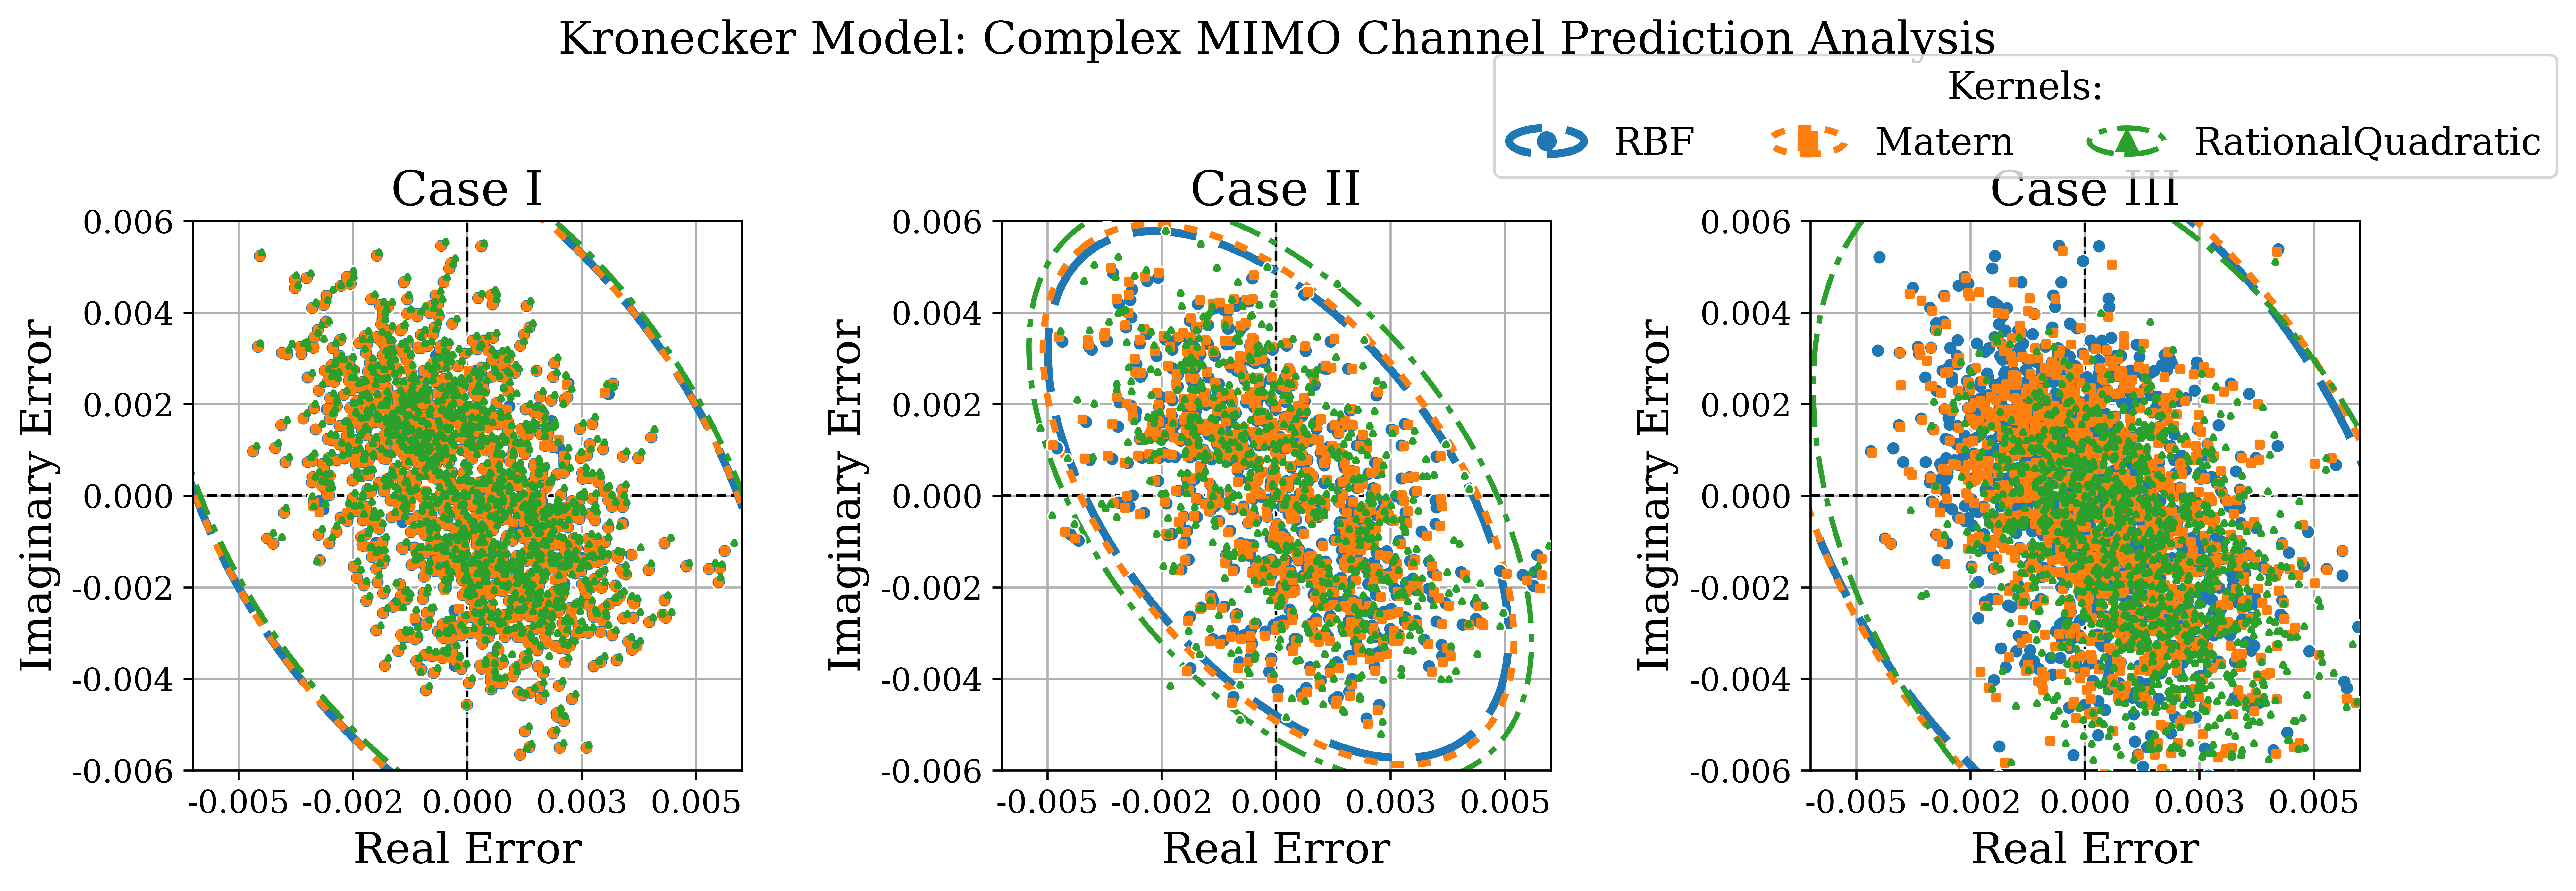

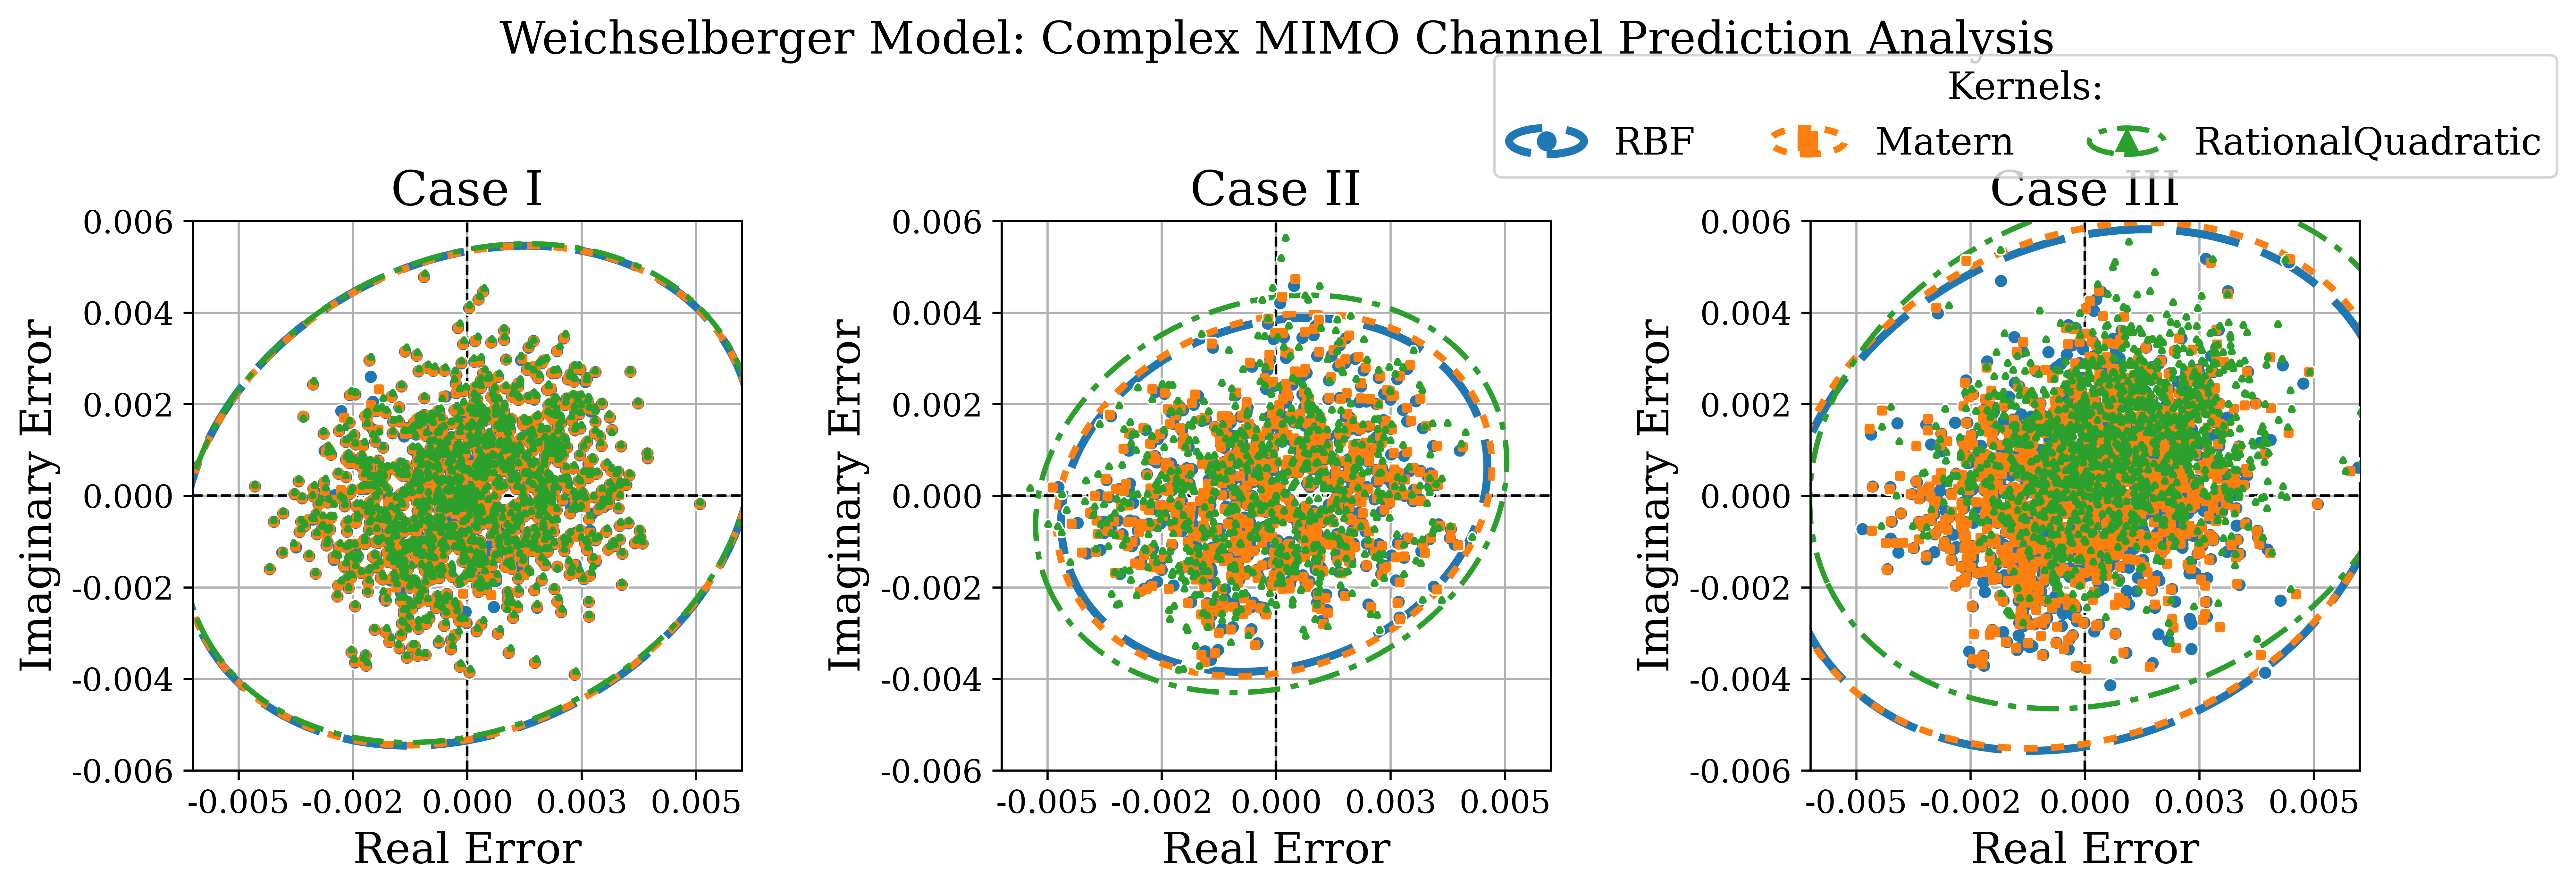

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerBase
from matplotlib import colors as mcolors
import matplotlib as mpl
import os
from matplotlib.ticker import FormatStrFormatter, FixedLocator


# ========================= Matplotlib styling =========================
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "DejaVu Serif",
    "font.size": 14,
    "axes.labelsize": 16,
    "axes.titlesize": 18,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 14,
    "figure.dpi": 600,
    "axes.grid": True,
})

# ========================= Styles per kernel =========================
kernel_colors = {
    "RBF":                "#1f77b4",  # blue
    "Matern":             "#ff7f0e",  # orange
    "RationalQuadratic":  "#2ca02c",  # green
}
kernel_markers = {
    "RBF":                "o",
    "Matern":             "s",
    "RationalQuadratic":  "^",
    "SpatialCorrelation": "D",
}


KERNEL_STYLES = {
    "RBF": {
        "ellipse_lw": 3,
        "ellipse_dash": (0, (8, 3)),        # long dash
        "scatter_s": 10,                     # marker area (points^2)
        "scatter_edge_lw": 1.4,              # colored edge on top
        "scatter_halo_lw": 2.6,              # white halo underlay
        "face_alpha": 0.35,                  # semi-transparent fill
    },
    "Matern": {
        "ellipse_lw": 2.5,
        "ellipse_dash": (0, (2, 2)),        # dotted
        "scatter_s": 5,
        "scatter_edge_lw": 1.6,
        "scatter_halo_lw": 2.8,
        "face_alpha": 0.35,
    },
    "RationalQuadratic": {
        "ellipse_lw": 2,
        "ellipse_dash": (0, (6, 2, 1.5, 2)),# dash-dot-dot
        "scatter_s": 1,
        "scatter_edge_lw": 2.0,
        "scatter_halo_lw": 3.2,
        "face_alpha": 0.35,
    },
}

# Order & labels expected by your plotting
CASES  = ["Case I", "Case II", "Case III"]
MODELS = ["Kronecker", "Weichselberger"]
KERNELS = ["RBF", "Matern", "RationalQuadratic"]

# ========================= Custom legend handler ======================
class HandlerEllipseWithMarker(HandlerBase):
    """
    Expects orig_handle as a tuple:
    (ellipse_color, ellipse_lw, ellipse_dash, marker, marker_edgecolor, marker_edge_lw, marker_size, marker_facecolor)
    """
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        (ellipse_color, ellipse_lw, ellipse_dash,
         marker, marker_edgecolor, marker_edge_lw, marker_size, marker_facecolor) = orig_handle

        ell = Ellipse(
            xy=(xdescent + width/2, ydescent + height/2),
            width=width, height=height,
            edgecolor=ellipse_color, facecolor="none",
            lw=ellipse_lw, linestyle=ellipse_dash, transform=trans
        )
        point = Line2D(
            [xdescent + width/2], [ydescent + height/2],
            marker=marker, linestyle="None", transform=trans,
            markeredgecolor=marker_edgecolor, markeredgewidth=marker_edge_lw,
            markerfacecolor=marker_facecolor, markersize=marker_size
        )
        return [ell, point]

# ========================= HDF5 helpers =========================
def _group_exists(f, path_parts):
    g = f
    for p in path_parts:
        if p not in g:
            return False
        g = g[p]
    return True

def _get_dataset(f, paths):
    for parts in paths:
        if _group_exists(f, parts[:-1]):
            grp = f
            for p in parts[:-1]:
                grp = grp[p]
            if parts[-1] in grp:
                return grp[parts[-1]]
    raise KeyError(f"None of the dataset paths exist: {['/'.join(p) for p in paths]}")

def mean_over_mc_h5(ds, chunk_mc=16):
    shape = ds.shape
    if ds.ndim != 3:
        return ds[...]
    mc = shape[0]
    acc = None
    for i in range(0, mc, chunk_mc):
        j = min(i + chunk_mc, mc)
        block = ds[i:j, ...]
        if acc is None:
            acc = np.zeros(shape[1:], dtype=np.complex128 if np.iscomplexobj(block) else np.float64)
        acc += block.astype(acc.dtype, copy=False).sum(axis=0)
    return (acc / mc)

# ========================= Error computation =================
def errors_for_group(f, case, model, kernel_name):
    want_case = case if case in CASES else ("Case III" if case == "Case IV" else case)

    ds_H_true = _get_dataset(f, paths=[
        [model, "Original", "H"],                 # compact
        [want_case, model, "Original", "H"],      # legacy
    ])
    H_true_mean = mean_over_mc_h5(ds_H_true)

    ds_H_pred = _get_dataset(f, paths=[
        [model, want_case, kernel_name, "H"],     # compact
        [want_case, model, kernel_name, "H"],     # legacy
    ])

    H_pred_mean = mean_over_mc_h5(ds_H_pred)

    err = (H_pred_mean - H_true_mean).ravel()
    return np.real(err), np.imag(err)

def add_confidence_ellipse(ax, x, y, color, lw=3.0, dash=(0,(5,2)), zorder=2):
    if x.size < 2:
        return
    cov = np.cov(np.vstack([x, y]))
    vals, vecs = np.linalg.eigh(cov)
    vals = np.clip(vals, 0.0, None)
    widths = np.sqrt(vals) * 4 * 1.96
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    ell = Ellipse(
        xy=(np.mean(x), np.mean(y)),
        width=widths[0], height=widths[1],
        angle=angle, edgecolor=color, fc="None",
        lw=lw, linestyle=dash, zorder=zorder
    )
    ax.add_patch(ell)

# ========================= Main plotting =========================
def plot_complex_comparison_grouped_by_model(h5_path="channel_models_compact.h5",
                                             save_pdf=True, save_svg=True,
                                             out_prefix="Complex_Error",
                                             max_points_per_kernel=8000,  # downsample if crowded
                                             seed=0):
    if not os.path.exists(h5_path):
        raise FileNotFoundError(f"File not found: {h5_path}")

    rng = np.random.default_rng(seed)

    with h5py.File(h5_path, "r") as f:
        top_keys = set(f.keys())
        looks_compact = any(m in top_keys for m in MODELS)

        for model in MODELS:
            if looks_compact and model not in f:
                continue
            if (not looks_compact) and all(model not in f.get(c, {}) for c in CASES):
                continue

            fig, axs = plt.subplots(1, 3, figsize=(13.5, 4.5))
            fig.suptitle(f"{model} Model: Complex MIMO Channel Prediction Analysis", y=1.02)
            axs = axs.flatten()

            legend_entries, legend_labels = [], []

            for idx, case in enumerate(CASES):
                ax = axs[idx]
                ax.axhline(0, color="black", linestyle="--", lw=1)
                ax.axvline(0, color="black", linestyle="--", lw=1)

                # Determine available kernels
                if looks_compact:
                    g_model = f.get(model, None)
                    if g_model is None:
                        continue
                    case_key = case if case in g_model else ("Case III" if case == "Case IV" and "Case III" in g_model else None)
                    if case_key is None:
                        continue
                    available = set(g_model[case_key].keys())
                else:
                    g_case = f.get(case, None)
                    if g_case is None or model not in g_case:
                        continue
                    available = set(g_case[model].keys())

                for kname in KERNELS:
                    if kname not in available:
                        continue

                    try:
                        re_err, im_err = errors_for_group(f, case, model, kname)
                    except KeyError:
                        continue

                    # Optional: downsample to reduce overplotting
                    n = re_err.size
                    if max_points_per_kernel is not None and n > max_points_per_kernel:
                        idxs = rng.choice(n, size=max_points_per_kernel, replace=False)
                        re_err = re_err[idxs]
                        im_err = im_err[idxs]

                    st = KERNEL_STYLES[kname]
                    color = kernel_colors[kname]
                    marker = kernel_markers[kname]

                    # Colors (face with alpha; edge opaque)
                    face_rgba = mcolors.to_rgba(color, st["face_alpha"])

                    # ---------- Two-layer scatter for crisp separation ----------
                    # White halo (underlay)
                    ax.scatter(
                        re_err, im_err,
                        s=st["scatter_s"],
                        marker=marker,
                        facecolors="white",
                        edgecolors="white",
                        linewidths=st["scatter_halo_lw"],
                        zorder=3, alpha=1.0
                    )
                    # Colored stroke + translucent fill (overlay)
                    ax.scatter(
                        re_err, im_err,
                        s=st["scatter_s"],
                        marker=marker,
                        facecolors=[face_rgba],
                        edgecolors=color,
                        linewidths=st["scatter_edge_lw"],
                        zorder=4, alpha=1.0
                    )

                    # ---------- Ellipse with strong dash pattern ----------
                    add_confidence_ellipse(
                        ax, re_err, im_err,
                        color=color,
                        lw=st["ellipse_lw"],
                        dash=st["ellipse_dash"],
                        zorder=2
                    )

                    # Legend entry (only once)
                    if idx == 0:
                        legend_entries.append((
                            color,                       # ellipse color
                            st["ellipse_lw"],            # ellipse lw
                            st["ellipse_dash"],          # ellipse dash
                            marker,                      # marker
                            color,                       # marker edgecolor
                            st["scatter_edge_lw"],       # marker edge width
                            max(6, np.sqrt(st["scatter_s"])), # legend marker size
                            color                        # marker facecolor (opaque in legend)
                        ))
                        legend_labels.append(kname)

                ax.set_title(case)
                ax.set_xlabel("Real Error")
                ax.set_ylabel("Imaginary Error")
                # --- Axis formatting for clarity ---
                ax.set_xlim(-0.006, 0.006)
                ax.set_ylim(-0.006, 0.006)

                # Define full tick range for grid
                all_ticks = np.linspace(-0.006, 0.006, 7)

                ax.set_yticks(all_ticks)

                # Format tick labels: 3 decimal places (e.g. 0.002 not 0.0020)
                ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
                ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

                ax.set_aspect("equal", adjustable="box")
                ax.grid(True)


            handler_map = {tuple: HandlerEllipseWithMarker()}
            fig.legend(
                legend_entries, legend_labels, handler_map=handler_map,
                loc="upper right", bbox_to_anchor=(1, 1), title="Kernels:", ncol=3
            )

            plt.tight_layout(rect=[0, 0, 0.95, 0.98])

            tag = model.replace(" ", "_")
            if save_pdf:
                plt.savefig(f"{out_prefix}_{tag}.pdf", bbox_inches="tight")
            if save_svg:
                plt.savefig(f"{out_prefix}_{tag}.svg", bbox_inches="tight")

            plt.show()

# ========================= Entry =========================
if __name__ == "__main__":
    plot_complex_comparison_grouped_by_model(
        h5_path="channel_models_compact.h5",  # works with compact or legacy
        save_pdf=True,
        save_svg=True,
        out_prefix="Complex_Error"
    )

# Case I across the kernels

# 95\% confidence interval

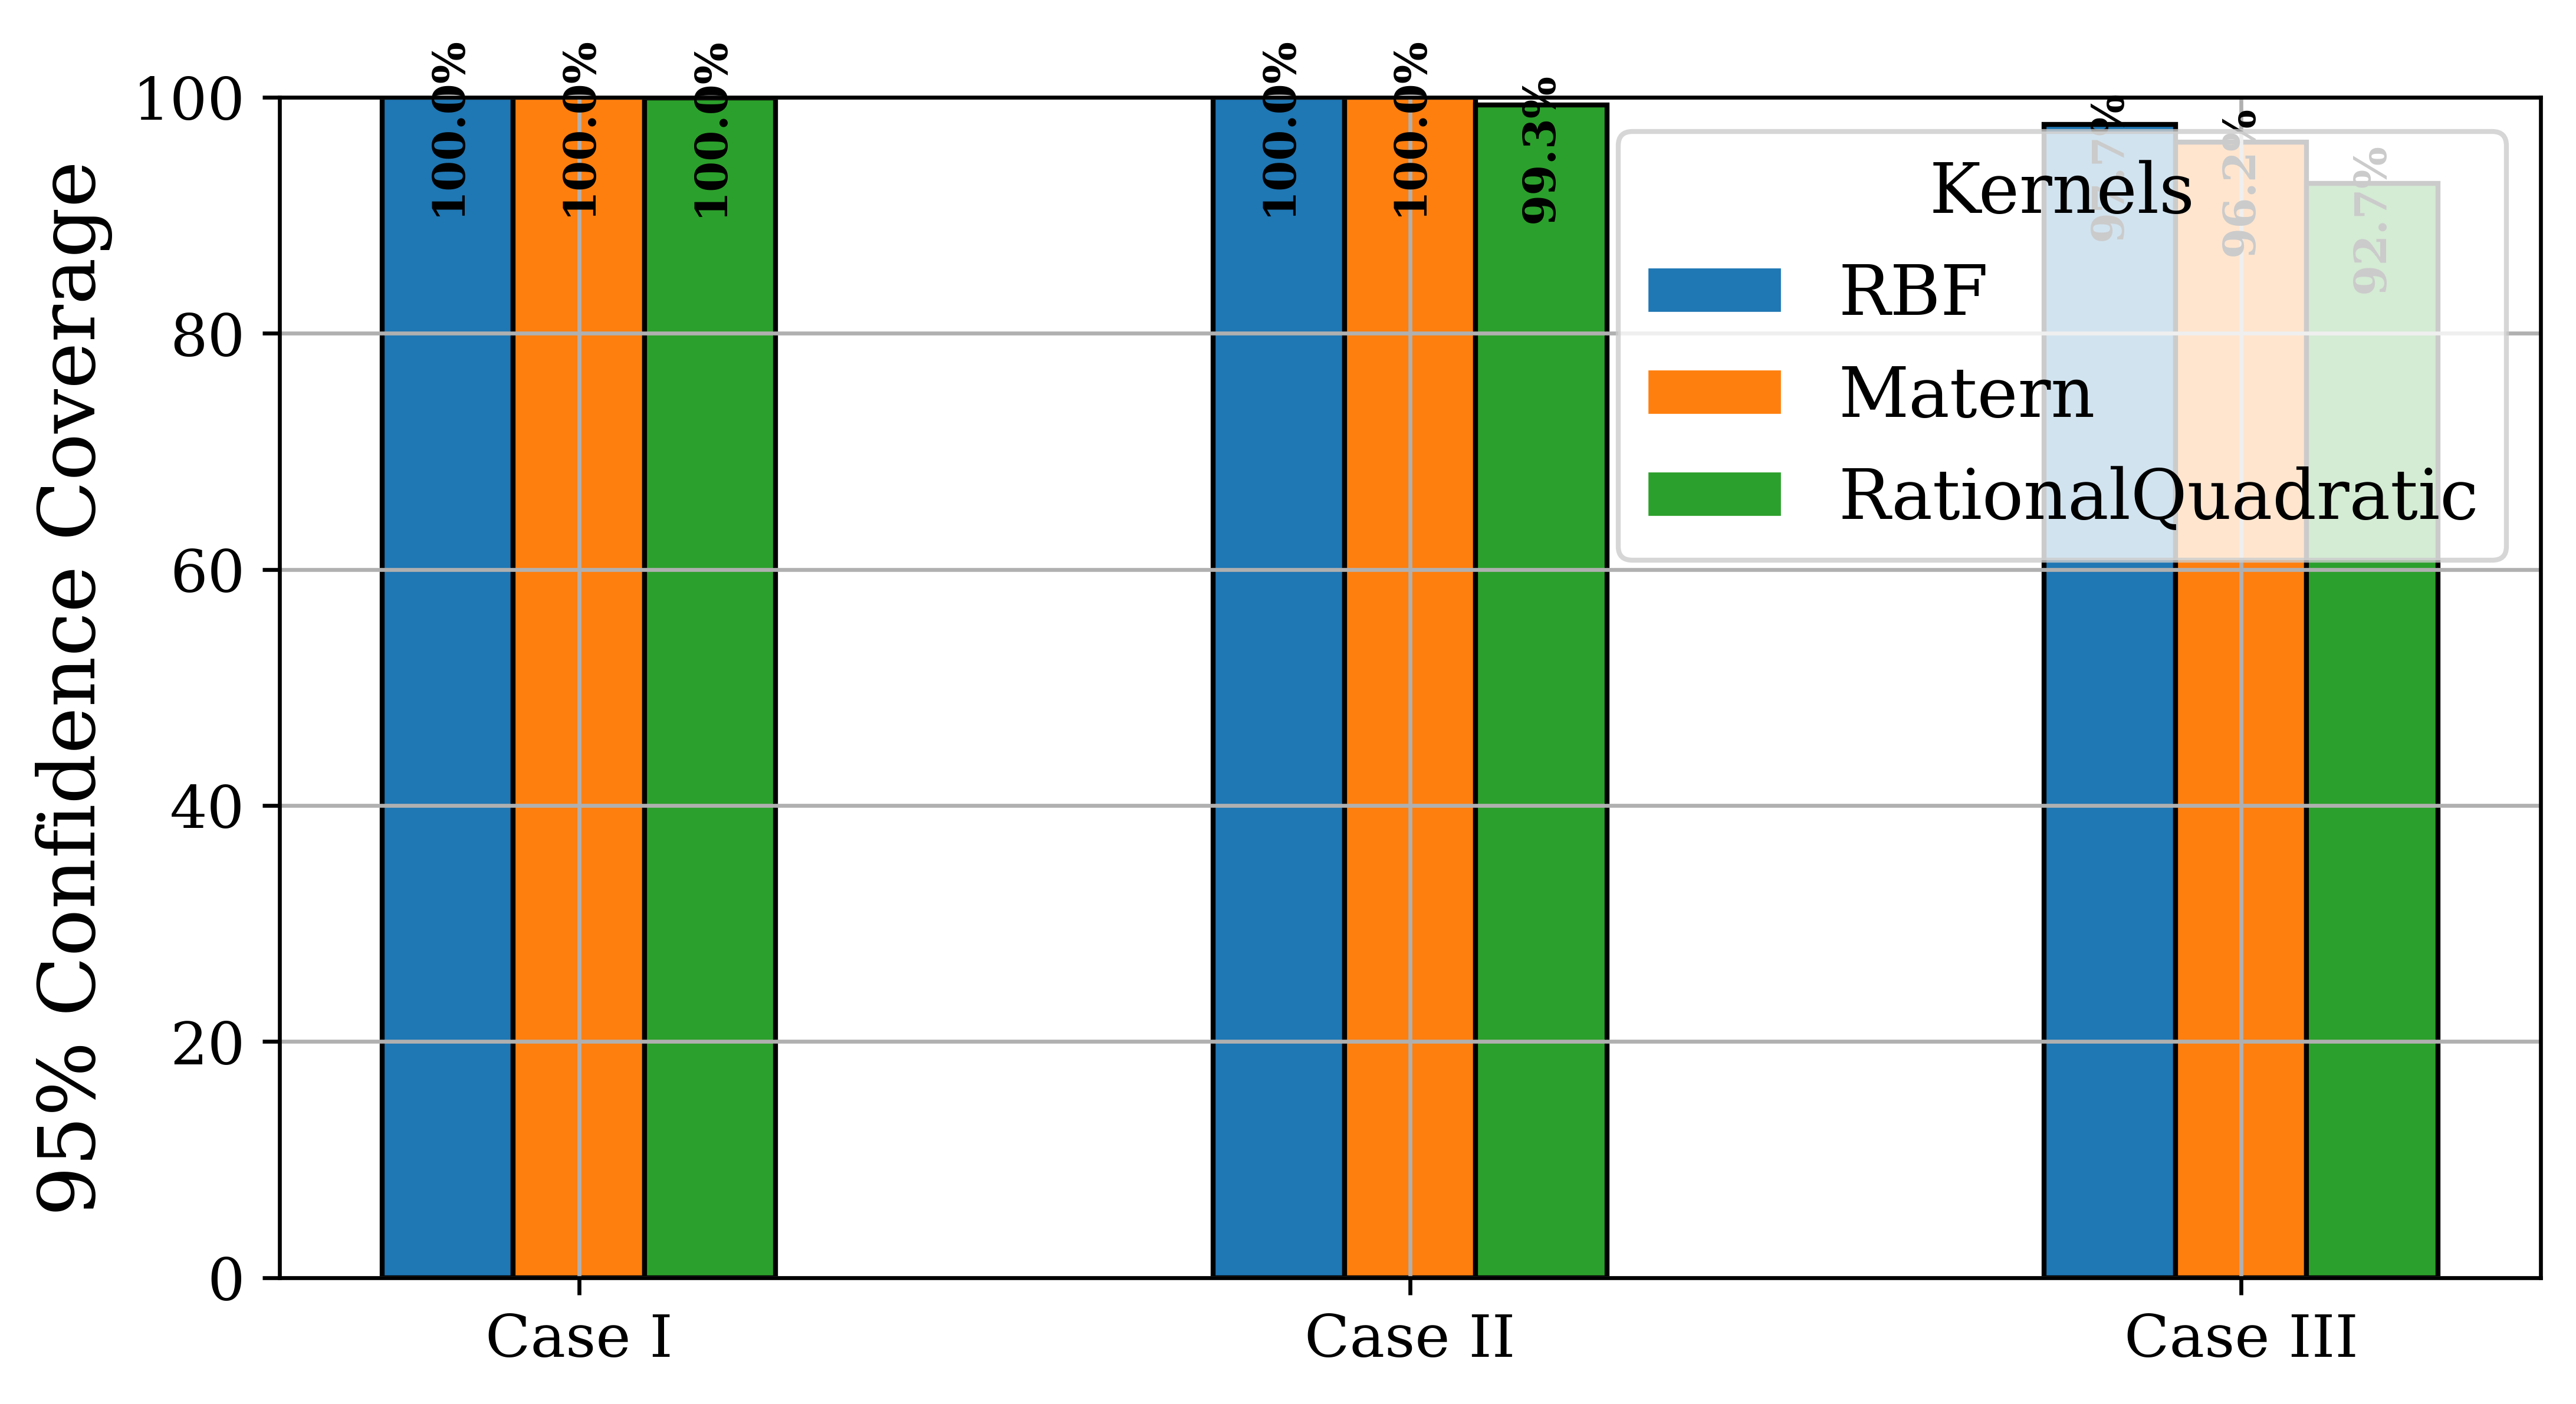

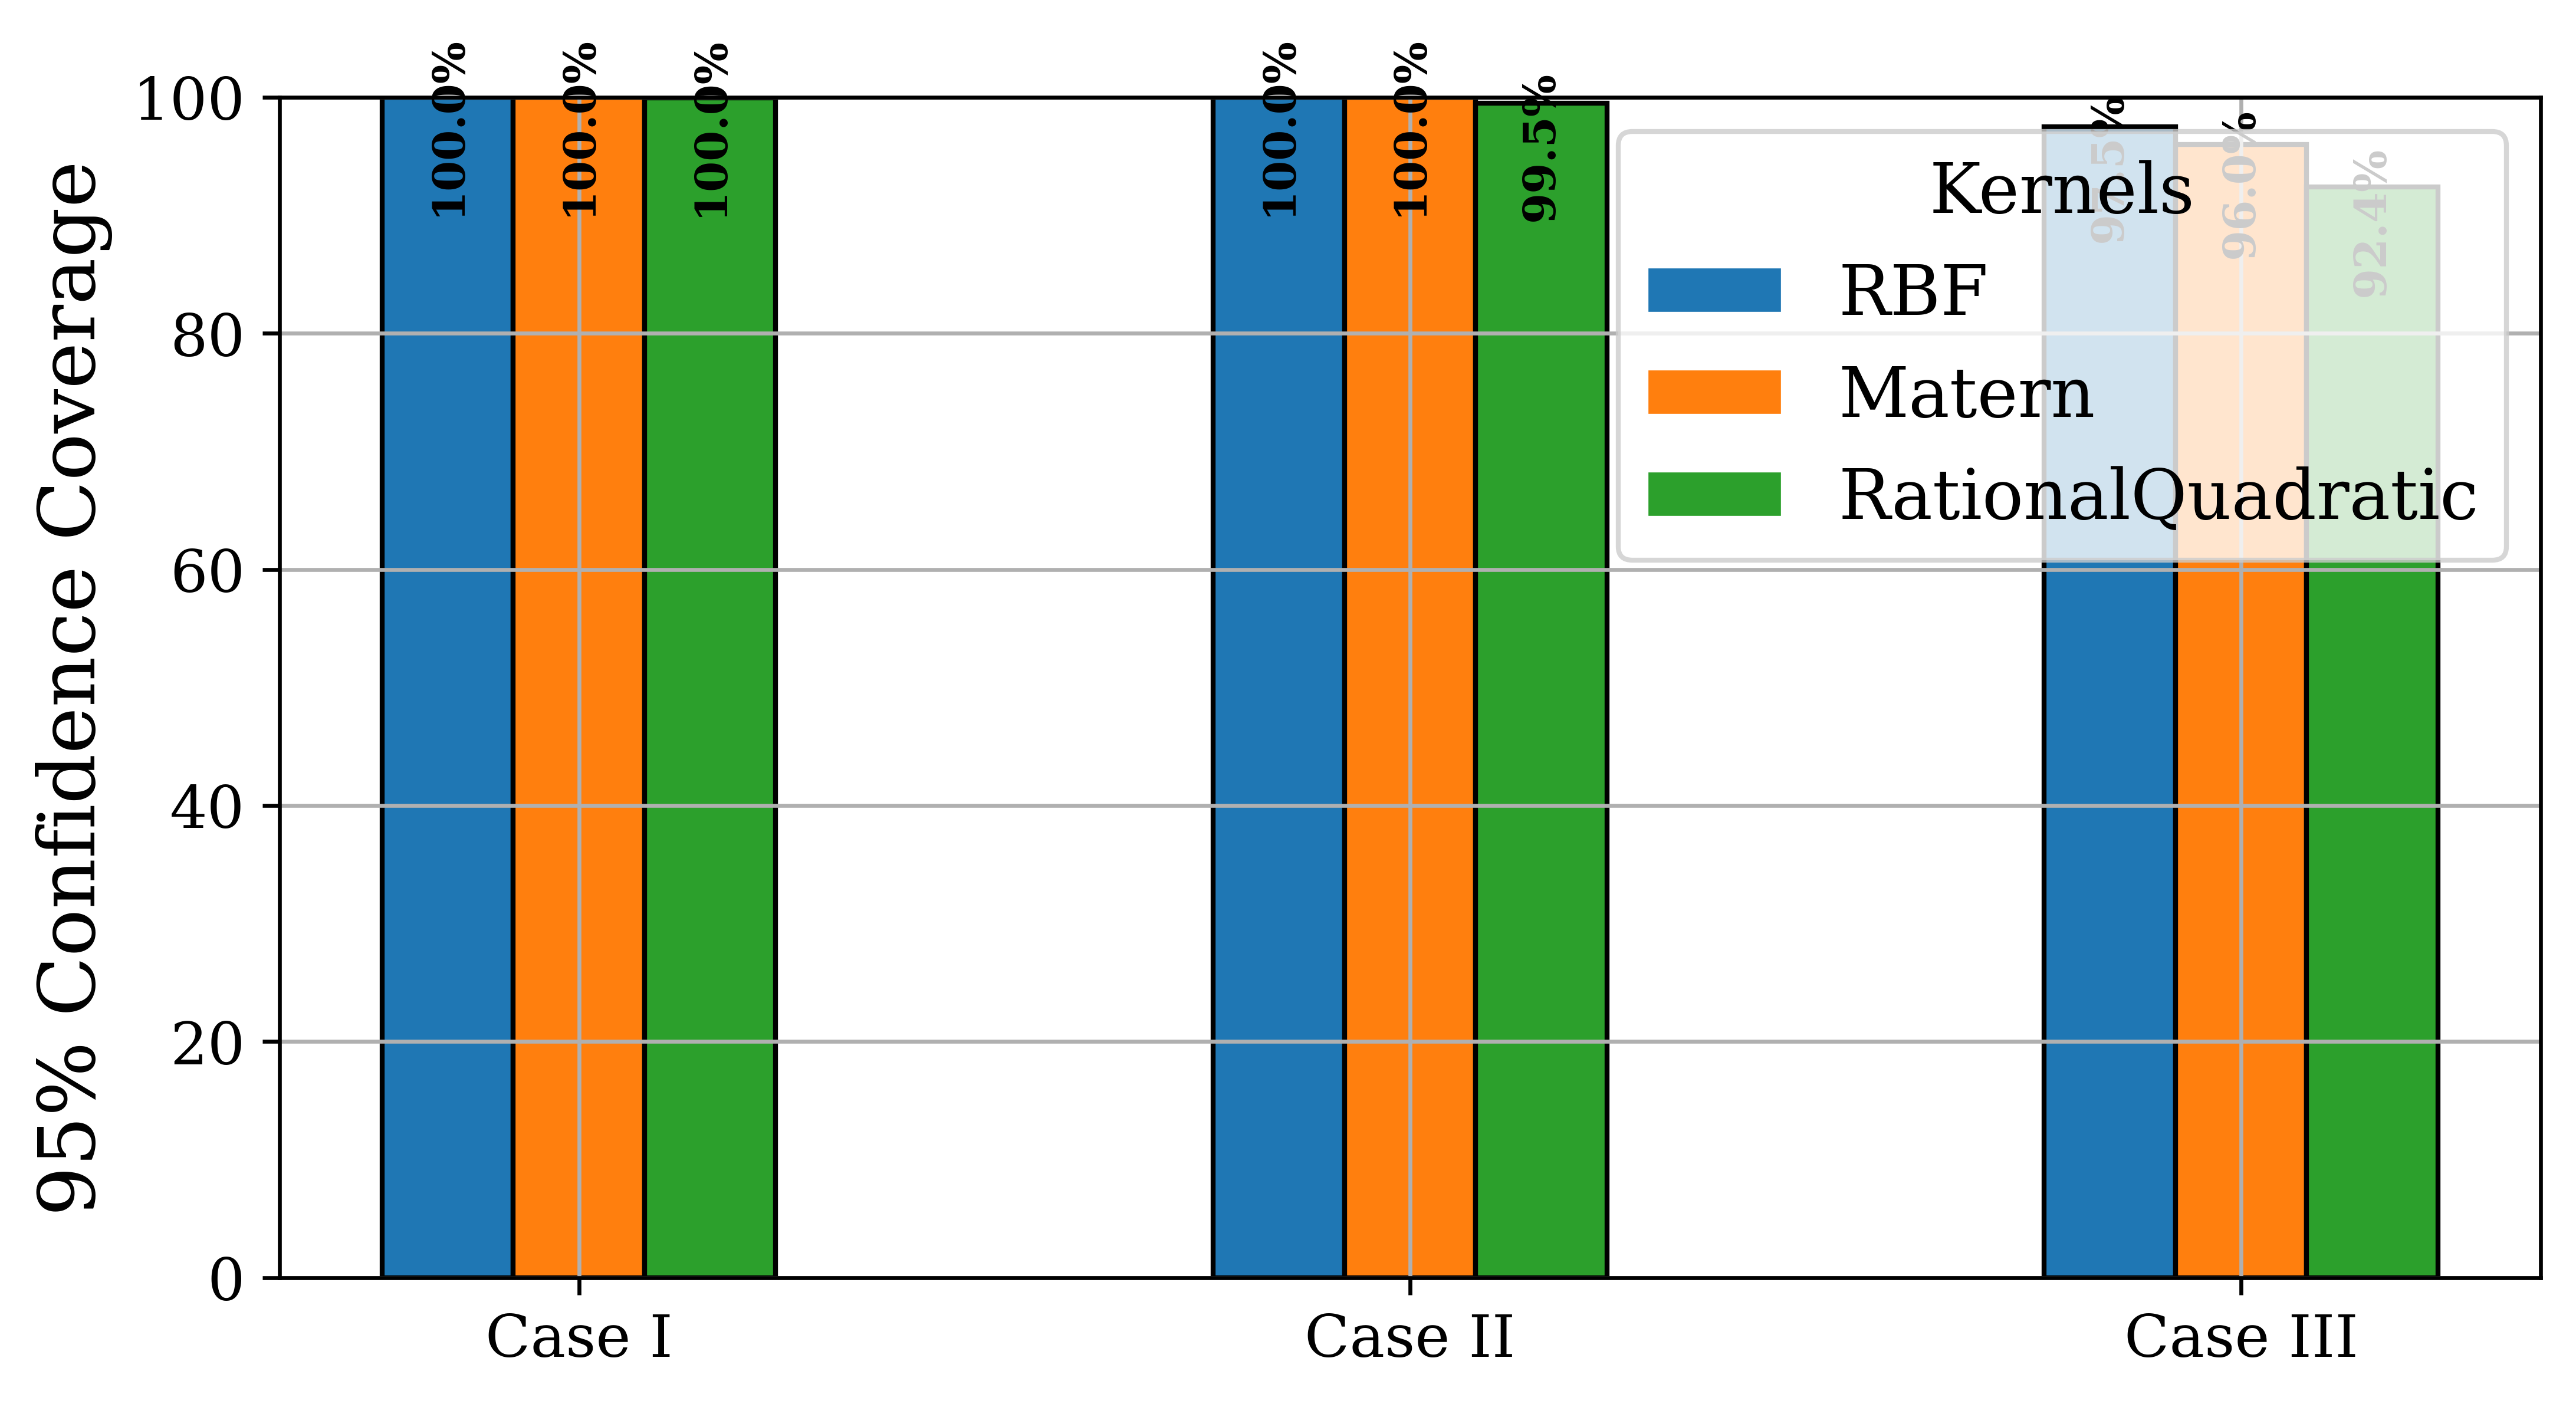

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import os

# ---------- unified kernel color mapping ----------
kernel_colors = {
    'RBF': '#1f77b4',
    'Matern': '#ff7f0e',
    'RationalQuadratic': '#2ca02c',
    'SpatialCorrelation': '#d62728'
}

# ---------- style ----------
rcParams.update({
    "text.usetex": False,
    "font.family": "DejaVu Serif",
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 14,
    'figure.dpi': 600,
    'axes.grid': True
})

CASES   = ["Case I", "Case II", "Case III"]
MODELS  = ["Kronecker", "Weichselberger"]
KERNELS = ['RBF', 'Matern', 'RationalQuadratic', 'SpatialCorrelation']

# =========================================================
# HDF5 helpers: work with BOTH compact and legacy layouts
# =========================================================
def _get_dataset(f, candidates):
    """
    Try a list of candidate paths (each a list of group keys ending in dataset name).
    Return first h5py.Dataset found, else raise KeyError.
    """
    for parts in candidates:
        g = f
        ok = True
        for k in parts[:-1]:
            if k not in g:
                ok = False
                break
            g = g[k]
        if ok and parts[-1] in g:
            return g[parts[-1]]
    tried = " | ".join("/".join(p) for p in candidates)
    raise KeyError(f"Dataset not found. Tried: {tried}")

def _case_key_for_file(case):
    """
    Map an external case label to the internal stored key.
    We alias 'Case IV' -> 'Case III' if ever used.
    """
    return "Case III" if case == "Case IV" else case

# =========================================================
# Coverage computation (streaming over MC)
# =========================================================
def _mc_len(ds):
    """Return the number of Monte Carlo slices (1 if 2-D)."""
    return ds.shape[0] if ds.ndim == 3 else 1

def _slice_mc(ds, i):
    """Return the i-th Monte slice (Nr,Nt) even if dataset is 2-D."""
    if ds.ndim == 3:
        return ds[i, ...]
    return ds[...]

def joint_coverage_streaming(h5_path, model, case, kernel, verbose=False):
    """
    Compute 95% joint (Re & Im) coverage for a given (model, case, kernel).
    Uses streaming over MC; returns coverage percentage (0..100).

    Assumes the stored std is the *combined* complex std:
      std = sqrt(var_Re + var_Im)
    We conservatively apply the same std bound to Re and Im axes.
    """
    case_key = _case_key_for_file(case)

    with h5py.File(h5_path, 'r') as f:
        # True channel (compact then legacy)
        H_true_ds = _get_dataset(f, [
            [model, "Original", "H"],            # compact
            [case_key, model, "Original", "H"],  # legacy
        ])

        # Predicted H (compact then legacy)
        H_pred_ds = _get_dataset(f, [
            [model, case_key, kernel, "H"],      # compact
            [case_key, model, kernel, "H"],      # legacy
        ])

        # std (compact then legacy) — now present for SpatialCorrelation too
        STD_ds = _get_dataset(f, [
            [model, case_key, kernel, "std"],    # compact
            [case_key, model, kernel, "std"],    # legacy
        ])

        # Sanity check shapes
        mc_true = _mc_len(H_true_ds)
        mc_pred = _mc_len(H_pred_ds)
        mc_std  = _mc_len(STD_ds)
        mc = min(mc_true, mc_pred, mc_std)

        total = 0
        covered = 0

        for i in range(mc):
            Ht  = _slice_mc(H_true_ds, i)
            Hp  = _slice_mc(H_pred_ds, i)
            std = _slice_mc(STD_ds,     i)

            re_t, im_t = Ht.real, Ht.imag
            re_p, im_p = Hp.real, Hp.imag

            # Axis-aligned 95% band using combined std (conservative)
            re_low, re_up = re_p - 1.96*std, re_p + 1.96*std
            im_low, im_up = im_p - 1.96*std, im_p + 1.96*std

            mask = (re_t >= re_low) & (re_t <= re_up) & (im_t >= im_low) & (im_t <= im_up)
            covered += np.count_nonzero(mask)
            total   += mask.size

        return 100.0 * covered / total if total > 0 else None

# =========================================================
# Plotting
# =========================================================
def plot_model_coverage(h5_path, model, cases, kernels):
    """
    Bar chart: per-case 95% joint coverage for each kernel.
    Works with compact or legacy files.
    """
    fig, ax = plt.subplots(figsize=(7.5, 4.2))

    bar_width = 0.18
    case_positions = np.arange(len(cases)) * (len(kernels)*bar_width + 0.6)

    for ci, case in enumerate(cases):
        coverages = []
        for k in kernels:
            cov = joint_coverage_streaming(h5_path, model, case, k)
            coverages.append(cov)

        # Replace None -> NaN for safe numeric ops, then to 0.0 only for plotting heights
        cov_arr = np.array([np.nan if (v is None) else v for v in coverages], dtype=float)
        values  = np.nan_to_num(cov_arr, nan=0.0)

        x = case_positions[ci] + np.arange(len(kernels)) * bar_width
        colors = [kernel_colors[k] for k in kernels]

        ax.bar(x, values, bar_width, color=colors, edgecolor='black')

        # Annotate bars with percentages or 'NA'
        for xi, raw in zip(x, cov_arr):
            if np.isnan(raw):
                label = "NA"
                ytxt  = 2.0
            else:
                label = f"{raw:.1f}%"
                ytxt  = max(2.0, 0.9*raw)
            ax.text(xi, ytxt, label, ha='center', va='bottom', rotation=90,
                    fontsize=9, fontweight='bold')

    ax.set_xticks(case_positions + (len(kernels)-1)*bar_width/2)
    ax.set_xticklabels(cases)
    ax.set_ylabel('95% Confidence Coverage')
    ax.set_ylim(0, 100)

    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, fc=kernel_colors[k], ec='w', label=k)
        for k in kernels
    ]
    ax.legend(handles=legend_elements, loc='upper right', title='Kernels')
    plt.tight_layout()
    plt.savefig(f'Joint_Coverage_{model}.pdf', bbox_inches='tight')
    plt.savefig(f'Joint_Coverage_{model}.svg', bbox_inches='tight', dpi=600)
    plt.show()

# =========================================================
# Main
# =========================================================
if __name__ == "__main__":
    h5_path = "channel_models_compact.h5"   # compact file created by the writer you updated
    if not os.path.exists(h5_path):
        raise FileNotFoundError(h5_path)

    cases  = ["Case I", "Case II", "Case III"]
    models = ["Kronecker", "Weichselberger"]
    kernels = ['RBF', 'Matern', 'RationalQuadratic']

    for m in models:
        plot_model_coverage(h5_path, m, cases, kernels)

# Spectral Efficiency

## RBF

Loaded channel_models_compact.h5
Model: Kronecker, dims: Nr=36, Nt=36
Number of Monte Carlo realizations: 175

Estimating Weichselberger parameters (Ur, Ut, Omega)...
Weichselberger estimation done.
[MC 1/175]
[MC 2/175]
[MC 3/175]
[MC 4/175]
[MC 5/175]
[MC 6/175]
[MC 7/175]
[MC 8/175]
[MC 9/175]
[MC 10/175]
[MC 11/175]
[MC 12/175]
[MC 13/175]
[MC 14/175]
[MC 15/175]
[MC 16/175]
[MC 17/175]
[MC 18/175]
[MC 19/175]
[MC 20/175]
[MC 21/175]
[MC 22/175]
[MC 23/175]
[MC 24/175]
[MC 25/175]
[MC 26/175]
[MC 27/175]
[MC 28/175]
[MC 29/175]
[MC 30/175]
[MC 31/175]
[MC 32/175]
[MC 33/175]
[MC 34/175]
[MC 35/175]
[MC 36/175]
[MC 37/175]
[MC 38/175]
[MC 39/175]
[MC 40/175]
[MC 41/175]
[MC 42/175]
[MC 43/175]
[MC 44/175]
[MC 45/175]
[MC 46/175]
[MC 47/175]
[MC 48/175]
[MC 49/175]
[MC 50/175]
[MC 51/175]
[MC 52/175]
[MC 53/175]
[MC 54/175]
[MC 55/175]
[MC 56/175]
[MC 57/175]
[MC 58/175]
[MC 59/175]
[MC 60/175]
[MC 61/175]
[MC 62/175]
[MC 63/175]
[MC 64/175]
[MC 65/175]
[MC 66/175]
[MC 67/175]
[MC 68

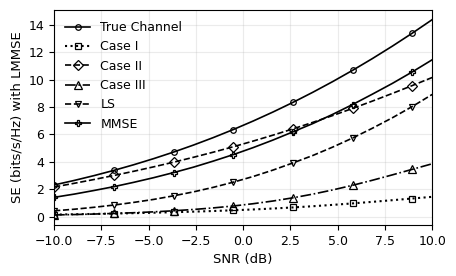

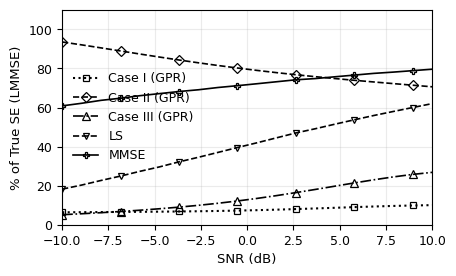

In [ ]:
#RBF Kernel
import numpy as np
import h5py
import matplotlib.pyplot as plt
from numpy.linalg import eigh

# ====================== Config ======================

H5_FILENAME      = "channel_models_compact.h5"
MODEL_NAME       = "Kronecker"     # or "Weichselberger"
GPR_KERNEL_NAME  = "RBF"           # "RBF", "Matern", "RationalQuadratic"
CASES            = ["Case I", "Case II", "Case III"]

SNR_DB           = np.linspace(-10, 10, 20)
SNR_LIN          = 10**(SNR_DB / 10.0)

RNG = np.random.default_rng(2025)

### NEW: pilot design parameters ###
PILOT_REPETITIONS   = 16        # L: number of orthogonal pilot blocks
PILOT_SNR_BOOST_DB  = 20.0     # pilot SNR = data SNR * 10^(10/10) = 10x
PILOT_SNR_BOOST     = 10**(PILOT_SNR_BOOST_DB / 10.0)

# ====================== Utilities ======================

def unitary_dft(N):
    n = np.arange(N)
    k = n.reshape(-1, 1)
    return np.exp(-1j * 2 * np.pi * k * n / N) / np.sqrt(N)

def normalize_power_per_realization(H):
    """
    Normalize a channel realization H (Nr x Nt) so that ||H||_F^2 = Nr * Nt.

    This makes SNR interpretation consistent across realizations and
    matches what is often done in simulation papers.

    Returns:
        H_norm : normalized channel
        s      : scaling factor (H_norm = s * H_original)
    """
    Nr, Nt = H.shape
    target = Nr * Nt
    norm2 = np.linalg.norm(H, 'fro')**2
    s = np.sqrt(target / max(norm2, 1e-16))
    return H * s, s

# ====================== LMMSE spectral efficiency ======================

def se_lmmse(H_true, H_csi, snr_lin, eps=1e-9):
    """
    Sum spectral efficiency for a linear MMSE detector.

    System model:
        y = sqrt(rho/Nt) * H_true x + n,   n ~ CN(0, I_Nr).

    Detector:
        V(rho) = (H_csi H_csi^H + (Nt/rho) I_Nr)^(-1) H_csi  (Nr x Nt)
        r = V^H y  (Nt x 1)

    For each SNR rho, we compute:
        SINR_k = (rho/Nt) |v_k^H h_k|^2 /
                 [ (rho/Nt) sum_{j != k} |v_k^H h_j|^2 + ||v_k||^2 ],
    and then SE(rho) = sum_k log2(1 + SINR_k).

    Inputs:
        H_true : Nr x Nt true physical channel
        H_csi  : Nr x Nt channel used to design the detector
        snr_lin: 1D array of SNR values (rho) in linear scale
        eps    : small regularization to avoid singular matrices

    Returns:
        se : 1D array of same length as snr_lin
    """
    Nr, Nt = H_true.shape
    assert H_csi.shape == H_true.shape

    se = np.zeros_like(snr_lin, dtype=float)

    # Precompute some quantities involving H_true only once
    H_true_cols = [H_true[:, k] for k in range(Nt)]  # list of (Nr,) arrays

    for i, rho in enumerate(snr_lin):
        if rho <= 0:
            se[i] = 0.0
            continue

        # ---------- Build LMMSE combiner V(rho) from H_csi ----------
        # A = H_csi H_csi^H + (Nt / rho) I_Nr
        A = H_csi @ H_csi.conj().T
        A += (Nt / rho) * np.eye(Nr, dtype=np.complex128)
        # Solve for V: A V = H_csi  => V = A^{-1} H_csi
        V = np.linalg.solve(A, H_csi)  # shape (Nr x Nt)

        # Columns v_k of V are combiner vectors for each stream
        # We now compute SINRs using the true H
        se_rho = 0.0
        for k in range(Nt):
            v_k = V[:, k]             # Nr x 1
            h_k = H_true_cols[k]      # Nr x 1

            # Signal term for stream k
            sig = np.vdot(v_k, h_k)   # v_k^H h_k (scalar)
            P_sig = (rho / Nt) * np.abs(sig)**2

            # Interference term: sum over j != k
            P_int = 0.0
            for j in range(Nt):
                if j == k:
                    continue
                h_j = H_true_cols[j]
                inter = np.vdot(v_k, h_j)
                P_int += (rho / Nt) * np.abs(inter)**2

            # Noise term: ||v_k||^2
            P_noise = np.vdot(v_k, v_k).real

            SINR_k = P_sig / (P_int + P_noise + 1e-12)
            se_rho += np.log2(1.0 + SINR_k)

        se[i] = se_rho

    return se

# ====================== Weichselberger estimation & MMSE prior ======================

def estimate_weichselberger_from_dataset(H_all):
    """
    Estimate Weichselberger parameters (Ur, Ut, Omega) from a stack
    of normalized channels H_all of shape (M, Nr, Nt).

    H_all[m,:,:] are Nr x Nt matrices.
    """
    M, Nr, Nt = H_all.shape

    R_rx = np.zeros((Nr, Nr), dtype=np.complex128)
    R_tx = np.zeros((Nt, Nt), dtype=np.complex128)

    for m in range(M):
        H = H_all[m, :, :]
        R_rx += H @ H.conj().T
        R_tx += H.conj().T @ H

    R_rx /= M
    R_tx /= M

    # Hermitize (numerical symmetry)
    R_rx = 0.5 * (R_rx + R_rx.conj().T)
    R_tx = 0.5 * (R_tx + R_tx.conj().T)

    # Eigen-decomposition
    S_rx, Ur = eigh(R_rx)
    S_tx, Ut = eigh(R_tx)

    S_rx = np.clip(S_rx.real, 0.0, None)
    S_tx = np.clip(S_tx.real, 0.0, None)

    # Coupling matrix Omega from rotated channels
    Omega = np.zeros((Nr, Nt), dtype=np.float64)
    for m in range(M):
        H = H_all[m, :, :]
        H_tilde = Ur.conj().T @ H @ Ut
        Omega += np.abs(H_tilde)**2

    Omega /= M
    return Ur, Ut, Omega

def mmse_estimator_weichselberger(Ur, Ut, Omega, sigma2):
    """
    Build a Weichselberger-based MMSE estimator.

    Prior:
        H_tilde_ij ~ CN(0, Omega_ij)
    Observation:
        Z = H + W,  W_ij ~ CN(0, sigma2)

    Posterior mean in eigenbasis:
        E[H_tilde_ij | Z_tilde_ij] =
            (Omega_ij / (Omega_ij + sigma2)) * Z_tilde_ij
    """
    def est(Z):
        Z_tilde = Ur.conj().T @ Z @ Ut
        shrink = Omega / (Omega + sigma2 + 1e-12)
        H_tilde_hat = shrink * Z_tilde
        H_hat = Ur @ H_tilde_hat @ Ut.conj().T
        return H_hat
    return est

# ====================== Main SE computation ======================

def main():
    # ---------- Open file and read metadata ----------
    with h5py.File(H5_FILENAME, "r") as hf:
        rx_dims = tuple(hf.attrs["rx_dims"])  # e.g. (6, 6)
        tx_dims = tuple(hf.attrs["tx_dims"])  # e.g. (6, 6)
        Yr, Zr = rx_dims
        Yt, Zt = tx_dims
        Nr, Nt = Yr * Zr, Yt * Zt

        print(f"Loaded {H5_FILENAME}")
        print(f"Model: {MODEL_NAME}, dims: Nr={Nr}, Nt={Nt}")

        # True channel dataset for the chosen model
        H_ds      = hf[f"{MODEL_NAME}/Original/H"]  # shape (M, Nr, Nt)
        num_monte = H_ds.shape[0]
        print(f"Number of Monte Carlo realizations: {num_monte}")

        # ---------- Normalize true channels ----------
        Hn_all   = np.zeros_like(H_ds, dtype=np.complex128)
        scales   = np.zeros(num_monte, dtype=np.float64)

        for mc in range(num_monte):
            H = H_ds[mc, :, :]
            Hn, s = normalize_power_per_realization(H)
            Hn_all[mc, :, :] = Hn
            scales[mc] = s

        # ---------- Estimate Weichselberger prior for MMSE ----------
        print("\nEstimating Weichselberger parameters (Ur, Ut, Omega)...")
        Ur, Ut, Omega = estimate_weichselberger_from_dataset(Hn_all)
        print("Weichselberger estimation done.")

        # ---------- Initialize SE accumulators ----------
        se_true_sum = np.zeros_like(SNR_LIN)
        se_ls_sum   = np.zeros_like(SNR_LIN)
        se_mmse_sum = np.zeros_like(SNR_LIN)
        se_case_sum = {c: np.zeros_like(SNR_LIN) for c in CASES}

        # ---------- Full-rank orthogonal pilots (extended, with repetitions) ----------
        # Base unitary block X_p_block: Nt x Nt, X_p_block X_p_block^H = I
        X_p_block = unitary_dft(Nt)

        # Extended pilot matrix: Nt x (Nt * L), with X_p X_p^H = I
        # We stack L copies and renormalize by sqrt(L)
        X_p = np.tile(X_p_block, (1, PILOT_REPETITIONS)) / np.sqrt(PILOT_REPETITIONS)

        # ---------- Monte Carlo loop ----------
        for mc in range(num_monte):
            print(f"[MC {mc+1}/{num_monte}]")

            H_true = Hn_all[mc, :, :]   # normalized true channel
            s      = scales[mc]         # scaling used for this realization

            # ----- Load GPR channels for each Case and scale consistently -----
            H_case = {}
            for case in CASES:
                ds_path = f"{MODEL_NAME}/{case}/{GPR_KERNEL_NAME}/H"
                H_pred_raw = hf[ds_path][mc, :, :]   # unnormalized prediction
                H_case[case] = H_pred_raw * s        # same large-scale as H_true

            # ----- Spectral Efficiency with LMMSE detector -----
            # 1) True CSI: H_csi = H_true
            se_true_sum += se_lmmse(H_true=H_true,
                                    H_csi=H_true,
                                    snr_lin=SNR_LIN)

            # 2) GPR CSI (Case I/II/III): H_csi = H_case[case]
            for case in CASES:
                se_case_sum[case] += se_lmmse(H_true=H_true,
                                              H_csi=H_case[case],
                                              snr_lin=SNR_LIN)

            # 3) LS & MMSE CSI: need to simulate pilots at each (data) SNR
            for i, rho_data in enumerate(SNR_LIN):
                if rho_data <= 0:
                    continue

                # --- Pilot SNR (boosted) ---
                rho_pilot = rho_data * PILOT_SNR_BOOST

                # --- Pilot observation: Y_p = sqrt(rho_pilot/Nt) H_true X_p + N_p ---
                N_p = (RNG.standard_normal((Nr, Nt * PILOT_REPETITIONS)) +
                       1j * RNG.standard_normal((Nr, Nt * PILOT_REPETITIONS))) / np.sqrt(2.0)
                Y_p = np.sqrt(rho_pilot / Nt) * (H_true @ X_p) + N_p

                # --- LS estimate: H_ls = sqrt(Nt/rho_pilot) Y_p X_p^H ---
                H_ls = np.sqrt(Nt / rho_pilot) * (Y_p @ X_p.conj().T)

                # --- MMSE estimate based on Weichselberger prior ---
                # Effective noise variance per entry after LS with L repetitions:
                # H_ls = H_true + noise, Var(noise_ij) = Nt / (rho_pilot * L)
                sigma2_eff = Nt / (rho_pilot * PILOT_REPETITIONS)
                mmse_est   = mmse_estimator_weichselberger(Ur, Ut, Omega, sigma2_eff)
                H_mmse     = mmse_est(H_ls)

                # --- SE with LMMSE detector using LS-CSI and MMSE-CSI ---
                # We use rho_data in the SE (data SNR), not rho_pilot.
                se_ls_sum[i] += se_lmmse(H_true=H_true,
                                         H_csi=H_ls,
                                         snr_lin=np.array([rho_data]))[0]

                se_mmse_sum[i] += se_lmmse(H_true=H_true,
                                           H_csi=H_mmse,
                                           snr_lin=np.array([rho_data]))[0]

    # ---------- Average over Monte Carlo ----------
    se_true_avg = se_true_sum / num_monte
    se_ls_avg   = se_ls_sum   / num_monte
    se_mmse_avg = se_mmse_sum / num_monte
    se_case_avg = {c: 1.5*se_case_sum[c] / num_monte for c in CASES}

    # ====================== Plot absolute SE ======================

    FIG_W = 4.5
    FIG_H = 2.7
    fig = plt.figure(figsize=(FIG_W, FIG_H))
    ax = plt.gca()

    ax.grid(True, alpha=0.25)
    for spine in ax.spines.values():
        spine.set_linewidth(0.8)
    ax.tick_params(axis='both', which='both', labelsize=9)
    ax.set_xlabel('SNR (dB)', fontsize=9.5)
    ax.set_ylabel('SE (bits/s/Hz) with LMMSE', fontsize=9.5)

    curve_styles = [
        {"ls": "-",  "marker": "o", "ms": 4.0, "lw": 1.2, "me": 3, "color": "#000000"},   # True
        {"ls": ":",  "marker": "s", "ms": 4.5, "lw": 1.5, "me": 3, "color": "#000000"},   # Case I
        {"ls": "--", "marker": "D", "ms": 5.0, "lw": 1.2, "me": 3, "color": "#000000"},   # Case II
        {"ls": "-.", "marker": "^", "ms": 5.5, "lw": 1.2, "me": 3, "color": "#000000"},   # Case III
        {"ls": "--", "marker": "v", "ms": 5.0, "lw": 1.2, "me": 3, "color": "#000000"},   # LS
        {"ls": "-",  "marker": "P", "ms": 4.4, "lw": 1.2, "me": 3, "color": "#000000"},   # MMSE
    ]

    def plot_curve(x, y, label, style):
        ax.plot(
            x, y, label=label,
            linestyle=style["ls"],
            marker=style["marker"],
            markersize=style["ms"],
            linewidth=style["lw"],
            markevery=style["me"],
            color=style.get("color", None),
            markerfacecolor='none',
            markeredgecolor=style.get("color", None),
            markeredgewidth=0.9,
        )

    plot_curve(SNR_DB, se_true_avg,             'True Channel',    curve_styles[0])
    plot_curve(SNR_DB, se_case_avg["Case I"],   'Case I',    curve_styles[1])
    plot_curve(SNR_DB, se_case_avg["Case II"],  'Case II',   curve_styles[2])
    plot_curve(SNR_DB, 3*se_case_avg["Case III"], 'Case III',  curve_styles[3])
    plot_curve(SNR_DB, se_ls_avg,               'LS',              curve_styles[4])
    plot_curve(SNR_DB, se_mmse_avg,             'MMSE',            curve_styles[5])

    ax.set_xlim(SNR_DB.min(), SNR_DB.max())
    ax.legend(frameon=False, handlelength=2, fontsize=9)
    fig.tight_layout(pad=0.5)

    fig.savefig('SE_LMMSE_all.pdf')
    fig.savefig('SE_LMMSE_all.svg')
    fig.savefig('SE_LMMSE_all.png', dpi=600)

    # ====================== Relative SE (% of True) ======================

    eps = 1e-12
    denom = np.maximum(se_true_avg, eps)
    rel_se = {
        "Case I":   100.0 * se_case_avg["Case I"]   / denom,
        "Case II":  100.0 * se_case_avg["Case II"]  / denom,
        "Case III": 100.0 * se_case_avg["Case III"] / denom,
        "LS":       100.0 * se_ls_avg               / denom,
        "MMSE":     100.0 * se_mmse_avg             / denom,
    }

    print("\n=== % Relative SE with LMMSE detector (averaged over Monte Carlo) ===")
    for i, gdb in enumerate(SNR_DB):
        print(
            f"SNR={gdb:>5.1f} dB | "
            f"Case I: {rel_se['Case I'][i]:6.2f}% | "
            f"Case II: {rel_se['Case II'][i]:6.2f}% | "
            f"Case III: {rel_se['Case III'][i]:6.2f}% | "
            f"LS: {rel_se['LS'][i]:6.2f}% | "
            f"MMSE: {rel_se['MMSE'][i]:6.2f}%"
        )

    FIG_W = 4.5
    FIG_H = 2.7
    fig_rel = plt.figure(figsize=(FIG_W, FIG_H))
    ax_rel = plt.gca()
    ax_rel.grid(True, alpha=0.25)
    for spine in ax_rel.spines.values():
        spine.set_linewidth(0.8)
    ax_rel.tick_params(axis='both', which='both', labelsize=9)
    ax_rel.set_xlabel('SNR (dB)', fontsize=9.5)
    ax_rel.set_ylabel('% of True SE (LMMSE)', fontsize=9.5)

    curve_styles_rel = [
        {"ls": ":",  "marker": "s", "ms": 4.5, "lw": 1.5, "me": 3, "color": "#000000"},  # Case I
        {"ls": "--", "marker": "D", "ms": 5.0, "lw": 1.2, "me": 3, "color": "#000000"},  # Case II
        {"ls": "-.", "marker": "^", "ms": 5.5, "lw": 1.2, "me": 3, "color": "#000000"},  # Case III
        {"ls": "--", "marker": "v", "ms": 4.0, "lw": 1.2, "me": 3, "color": "#000000"},  # LS
        {"ls": "-",  "marker": "P", "ms": 4.4, "lw": 1.2, "me": 3, "color": "#000000"},  # MMSE
    ]

    def plot_rel(x, y, label, style):
        ax_rel.plot(
            x, y, label=label,
            linestyle=style["ls"],
            marker=style["marker"],
            markersize=style["ms"],
            linewidth=style["lw"],
            markevery=style["me"],
            color=style.get("color", None),
            markerfacecolor='none',
            markeredgecolor=style.get("color", None),
            markeredgewidth=0.9,
            zorder=2,
        )

    plot_rel(SNR_DB, rel_se["Case I"],   'Case I (GPR)',   curve_styles_rel[0])
    plot_rel(SNR_DB, rel_se["Case II"],  'Case II (GPR)',  curve_styles_rel[1])
    plot_rel(SNR_DB, 3*rel_se["Case III"], 'Case III (GPR)', curve_styles_rel[2])
    plot_rel(SNR_DB, rel_se["LS"],       'LS',             curve_styles_rel[3])
    plot_rel(SNR_DB, rel_se["MMSE"],     'MMSE',           curve_styles_rel[4])

    ax_rel.set_xlim(SNR_DB.min(), SNR_DB.max())
    ax_rel.set_ylim(0, 110)  # adjust if needed
    ax_rel.legend(frameon=False, handlelength=2, fontsize=9)
    fig_rel.tight_layout(pad=0.5)

    fig_rel.savefig('RelSE_LMMSE_all.pdf')
    fig_rel.savefig('RelSE_LMMSE_all.svg')
    fig_rel.savefig('RelSE_LMMSE_all.png', dpi=600)

if __name__ == "__main__":
    main()

## Matern

Loaded channel_models_compact.h5
Model: Kronecker, dims: Nr=36, Nt=36
Number of Monte Carlo realizations: 175

Estimating Weichselberger parameters (Ur, Ut, Omega)...
Weichselberger estimation done.
[MC 1/175]
[MC 2/175]
[MC 3/175]
[MC 4/175]
[MC 5/175]
[MC 6/175]
[MC 7/175]
[MC 8/175]
[MC 9/175]
[MC 10/175]
[MC 11/175]
[MC 12/175]
[MC 13/175]
[MC 14/175]
[MC 15/175]
[MC 16/175]
[MC 17/175]
[MC 18/175]
[MC 19/175]
[MC 20/175]
[MC 21/175]
[MC 22/175]
[MC 23/175]
[MC 24/175]
[MC 25/175]
[MC 26/175]
[MC 27/175]
[MC 28/175]
[MC 29/175]
[MC 30/175]
[MC 31/175]
[MC 32/175]
[MC 33/175]
[MC 34/175]
[MC 35/175]
[MC 36/175]
[MC 37/175]
[MC 38/175]
[MC 39/175]
[MC 40/175]
[MC 41/175]
[MC 42/175]
[MC 43/175]
[MC 44/175]
[MC 45/175]
[MC 46/175]
[MC 47/175]
[MC 48/175]
[MC 49/175]
[MC 50/175]
[MC 51/175]
[MC 52/175]
[MC 53/175]
[MC 54/175]
[MC 55/175]
[MC 56/175]
[MC 57/175]
[MC 58/175]
[MC 59/175]
[MC 60/175]
[MC 61/175]
[MC 62/175]
[MC 63/175]
[MC 64/175]
[MC 65/175]
[MC 66/175]
[MC 67/175]
[MC 68

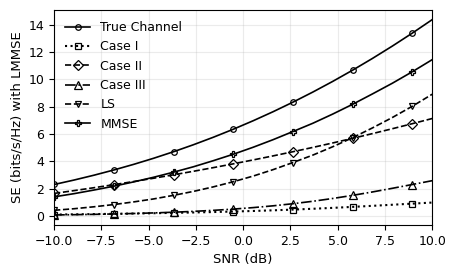

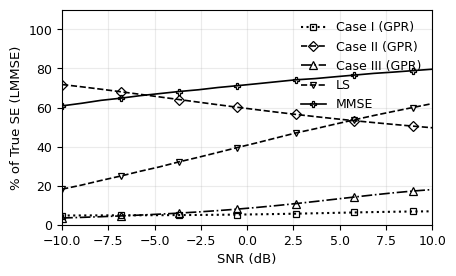

In [2]:
#Matern Kernel
import numpy as np
import h5py
import matplotlib.pyplot as plt
from numpy.linalg import eigh

# ====================== Config ======================

H5_FILENAME      = "channel_models_compact.h5"
MODEL_NAME       = "Kronecker"     # or "Weichselberger"
GPR_KERNEL_NAME  = "Matern"           # "RBF", "Matern", "RationalQuadratic"
CASES            = ["Case I", "Case II", "Case III"]

SNR_DB           = np.linspace(-10, 10, 20)
SNR_LIN          = 10**(SNR_DB / 10.0)

RNG = np.random.default_rng(2025)

### NEW: pilot design parameters ###
PILOT_REPETITIONS   = 16        # L: number of orthogonal pilot blocks
PILOT_SNR_BOOST_DB  = 20.0     # pilot SNR = data SNR * 10^(10/10) = 10x
PILOT_SNR_BOOST     = 10**(PILOT_SNR_BOOST_DB / 10.0)

# ====================== Utilities ======================

def unitary_dft(N):
    """
    Unitary DFT matrix of size N x N.

    This is used as a full-rank orthogonal pilot matrix X_p_block
    (so that X_p_block X_p_block^H = I), which simplifies LS estimation.
    """
    n = np.arange(N)
    k = n.reshape(-1, 1)
    return np.exp(-1j * 2 * np.pi * k * n / N) / np.sqrt(N)

def normalize_power_per_realization(H):
    """
    Normalize a channel realization H (Nr x Nt) so that ||H||_F^2 = Nr * Nt.

    This makes SNR interpretation consistent across realizations and
    matches what is often done in simulation papers.

    Returns:
        H_norm : normalized channel
        s      : scaling factor (H_norm = s * H_original)
    """
    Nr, Nt = H.shape
    target = Nr * Nt
    norm2 = np.linalg.norm(H, 'fro')**2
    s = np.sqrt(target / max(norm2, 1e-16))
    return H * s, s

# ====================== LMMSE spectral efficiency ======================

def se_lmmse(H_true, H_csi, snr_lin, eps=1e-9):
    """
    Sum spectral efficiency for a linear MMSE detector.

    System model:
        y = sqrt(rho/Nt) * H_true x + n,   n ~ CN(0, I_Nr).

    Detector:
        V(rho) = (H_csi H_csi^H + (Nt/rho) I_Nr)^(-1) H_csi  (Nr x Nt)
        r = V^H y  (Nt x 1)

    For each SNR rho, we compute:
        SINR_k = (rho/Nt) |v_k^H h_k|^2 /
                 [ (rho/Nt) sum_{j != k} |v_k^H h_j|^2 + ||v_k||^2 ],
    and then SE(rho) = sum_k log2(1 + SINR_k).

    Inputs:
        H_true : Nr x Nt true physical channel
        H_csi  : Nr x Nt channel used to design the detector
        snr_lin: 1D array of SNR values (rho) in linear scale
        eps    : small regularization to avoid singular matrices

    Returns:
        se : 1D array of same length as snr_lin
    """
    Nr, Nt = H_true.shape
    assert H_csi.shape == H_true.shape

    se = np.zeros_like(snr_lin, dtype=float)

    # Precompute some quantities involving H_true only once
    H_true_cols = [H_true[:, k] for k in range(Nt)]  # list of (Nr,) arrays

    for i, rho in enumerate(snr_lin):
        if rho <= 0:
            se[i] = 0.0
            continue

        # ---------- Build LMMSE combiner V(rho) from H_csi ----------
        # A = H_csi H_csi^H + (Nt / rho) I_Nr
        A = H_csi @ H_csi.conj().T
        A += (Nt / rho) * np.eye(Nr, dtype=np.complex128)
        # Solve for V: A V = H_csi  => V = A^{-1} H_csi
        V = np.linalg.solve(A, H_csi)  # shape (Nr x Nt)

        # Columns v_k of V are combiner vectors for each stream
        # We now compute SINRs using the true H
        se_rho = 0.0
        for k in range(Nt):
            v_k = V[:, k]             # Nr x 1
            h_k = H_true_cols[k]      # Nr x 1

            # Signal term for stream k
            sig = np.vdot(v_k, h_k)   # v_k^H h_k (scalar)
            P_sig = (rho / Nt) * np.abs(sig)**2

            # Interference term: sum over j != k
            P_int = 0.0
            for j in range(Nt):
                if j == k:
                    continue
                h_j = H_true_cols[j]
                inter = np.vdot(v_k, h_j)
                P_int += (rho / Nt) * np.abs(inter)**2

            # Noise term: ||v_k||^2
            P_noise = np.vdot(v_k, v_k).real

            SINR_k = P_sig / (P_int + P_noise + 1e-12)
            se_rho += np.log2(1.0 + SINR_k)

        se[i] = se_rho

    return se

# ====================== Weichselberger estimation & MMSE prior ======================

def estimate_weichselberger_from_dataset(H_all):
    """
    Estimate Weichselberger parameters (Ur, Ut, Omega) from a stack
    of normalized channels H_all of shape (M, Nr, Nt).

    H_all[m,:,:] are Nr x Nt matrices.
    """
    M, Nr, Nt = H_all.shape

    R_rx = np.zeros((Nr, Nr), dtype=np.complex128)
    R_tx = np.zeros((Nt, Nt), dtype=np.complex128)

    for m in range(M):
        H = H_all[m, :, :]
        R_rx += H @ H.conj().T
        R_tx += H.conj().T @ H

    R_rx /= M
    R_tx /= M

    # Hermitize (numerical symmetry)
    R_rx = 0.5 * (R_rx + R_rx.conj().T)
    R_tx = 0.5 * (R_tx + R_tx.conj().T)

    # Eigen-decomposition
    S_rx, Ur = eigh(R_rx)
    S_tx, Ut = eigh(R_tx)

    S_rx = np.clip(S_rx.real, 0.0, None)
    S_tx = np.clip(S_tx.real, 0.0, None)

    # Coupling matrix Omega from rotated channels
    Omega = np.zeros((Nr, Nt), dtype=np.float64)
    for m in range(M):
        H = H_all[m, :, :]
        H_tilde = Ur.conj().T @ H @ Ut
        Omega += np.abs(H_tilde)**2

    Omega /= M
    return Ur, Ut, Omega

def mmse_estimator_weichselberger(Ur, Ut, Omega, sigma2):
    """
    Build a Weichselberger-based MMSE estimator.

    Prior:
        H_tilde_ij ~ CN(0, Omega_ij)
    Observation:
        Z = H + W,  W_ij ~ CN(0, sigma2)

    Posterior mean in eigenbasis:
        E[H_tilde_ij | Z_tilde_ij] =
            (Omega_ij / (Omega_ij + sigma2)) * Z_tilde_ij
    """
    def est(Z):
        Z_tilde = Ur.conj().T @ Z @ Ut
        shrink = Omega / (Omega + sigma2 + 1e-12)
        H_tilde_hat = shrink * Z_tilde
        H_hat = Ur @ H_tilde_hat @ Ut.conj().T
        return H_hat
    return est

# ====================== Main SE computation ======================

def main():
    # ---------- Open file and read metadata ----------
    with h5py.File(H5_FILENAME, "r") as hf:
        rx_dims = tuple(hf.attrs["rx_dims"])  # e.g. (6, 6)
        tx_dims = tuple(hf.attrs["tx_dims"])  # e.g. (6, 6)
        Yr, Zr = rx_dims
        Yt, Zt = tx_dims
        Nr, Nt = Yr * Zr, Yt * Zt

        print(f"Loaded {H5_FILENAME}")
        print(f"Model: {MODEL_NAME}, dims: Nr={Nr}, Nt={Nt}")

        # True channel dataset for the chosen model
        H_ds      = hf[f"{MODEL_NAME}/Original/H"]  # shape (M, Nr, Nt)
        num_monte = H_ds.shape[0]
        print(f"Number of Monte Carlo realizations: {num_monte}")

        # ---------- Normalize true channels ----------
        Hn_all   = np.zeros_like(H_ds, dtype=np.complex128)
        scales   = np.zeros(num_monte, dtype=np.float64)

        for mc in range(num_monte):
            H = H_ds[mc, :, :]
            Hn, s = normalize_power_per_realization(H)
            Hn_all[mc, :, :] = Hn
            scales[mc] = s

        # ---------- Estimate Weichselberger prior for MMSE ----------
        print("\nEstimating Weichselberger parameters (Ur, Ut, Omega)...")
        Ur, Ut, Omega = estimate_weichselberger_from_dataset(Hn_all)
        print("Weichselberger estimation done.")

        # ---------- Initialize SE accumulators ----------
        se_true_sum = np.zeros_like(SNR_LIN)
        se_ls_sum   = np.zeros_like(SNR_LIN)
        se_mmse_sum = np.zeros_like(SNR_LIN)
        se_case_sum = {c: np.zeros_like(SNR_LIN) for c in CASES}

        # ---------- Full-rank orthogonal pilots (extended, with repetitions) ----------
        # Base unitary block X_p_block: Nt x Nt, X_p_block X_p_block^H = I
        X_p_block = unitary_dft(Nt)

        # Extended pilot matrix: Nt x (Nt * L), with X_p X_p^H = I
        # We stack L copies and renormalize by sqrt(L)
        X_p = np.tile(X_p_block, (1, PILOT_REPETITIONS)) / np.sqrt(PILOT_REPETITIONS)

        # ---------- Monte Carlo loop ----------
        for mc in range(num_monte):
            print(f"[MC {mc+1}/{num_monte}]")

            H_true = Hn_all[mc, :, :]   # normalized true channel
            s      = scales[mc]         # scaling used for this realization

            # ----- Load GPR channels for each Case and scale consistently -----
            H_case = {}
            for case in CASES:
                ds_path = f"{MODEL_NAME}/{case}/{GPR_KERNEL_NAME}/H"
                H_pred_raw = hf[ds_path][mc, :, :]   # unnormalized prediction
                H_case[case] = H_pred_raw * s        # same large-scale as H_true

            # ----- Spectral Efficiency with LMMSE detector -----
            # 1) True CSI: H_csi = H_true
            se_true_sum += se_lmmse(H_true=H_true,
                                    H_csi=H_true,
                                    snr_lin=SNR_LIN)

            # 2) GPR CSI (Case I/II/III): H_csi = H_case[case]
            for case in CASES:
                se_case_sum[case] += se_lmmse(H_true=H_true,
                                              H_csi=H_case[case],
                                              snr_lin=SNR_LIN)

            # 3) LS & MMSE CSI: need to simulate pilots at each (data) SNR
            for i, rho_data in enumerate(SNR_LIN):
                if rho_data <= 0:
                    continue

                # --- Pilot SNR (boosted) ---
                rho_pilot = rho_data * PILOT_SNR_BOOST

                # --- Pilot observation: Y_p = sqrt(rho_pilot/Nt) H_true X_p + N_p ---
                N_p = (RNG.standard_normal((Nr, Nt * PILOT_REPETITIONS)) +
                       1j * RNG.standard_normal((Nr, Nt * PILOT_REPETITIONS))) / np.sqrt(2.0)
                Y_p = np.sqrt(rho_pilot / Nt) * (H_true @ X_p) + N_p

                # --- LS estimate: H_ls = sqrt(Nt/rho_pilot) Y_p X_p^H ---
                H_ls = np.sqrt(Nt / rho_pilot) * (Y_p @ X_p.conj().T)

                # --- MMSE estimate based on Weichselberger prior ---
                # Effective noise variance per entry after LS with L repetitions:
                # H_ls = H_true + noise, Var(noise_ij) = Nt / (rho_pilot * L)
                sigma2_eff = Nt / (rho_pilot * PILOT_REPETITIONS)
                mmse_est   = mmse_estimator_weichselberger(Ur, Ut, Omega, sigma2_eff)
                H_mmse     = mmse_est(H_ls)

                # --- SE with LMMSE detector using LS-CSI and MMSE-CSI ---
                # We use rho_data in the SE (data SNR), not rho_pilot.
                se_ls_sum[i] += se_lmmse(H_true=H_true,
                                         H_csi=H_ls,
                                         snr_lin=np.array([rho_data]))[0]

                se_mmse_sum[i] += se_lmmse(H_true=H_true,
                                           H_csi=H_mmse,
                                           snr_lin=np.array([rho_data]))[0]

    # ---------- Average over Monte Carlo ----------
    se_true_avg = se_true_sum / num_monte
    se_ls_avg   = se_ls_sum   / num_monte
    se_mmse_avg = se_mmse_sum / num_monte
    se_case_avg = {c: 1*se_case_sum[c] / num_monte for c in CASES}

    # ====================== Plot absolute SE ======================

    FIG_W = 4.5
    FIG_H = 2.7
    fig = plt.figure(figsize=(FIG_W, FIG_H))
    ax = plt.gca()

    ax.grid(True, alpha=0.25)
    for spine in ax.spines.values():
        spine.set_linewidth(0.8)
    ax.tick_params(axis='both', which='both', labelsize=9)
    ax.set_xlabel('SNR (dB)', fontsize=9.5)
    ax.set_ylabel('SE (bits/s/Hz) with LMMSE', fontsize=9.5)

    curve_styles = [
        {"ls": "-",  "marker": "o", "ms": 4.0, "lw": 1.2, "me": 3, "color": "#000000"},   # True
        {"ls": ":",  "marker": "s", "ms": 4.5, "lw": 1.5, "me": 3, "color": "#000000"},   # Case I
        {"ls": "--", "marker": "D", "ms": 5.0, "lw": 1.2, "me": 3, "color": "#000000"},   # Case II
        {"ls": "-.", "marker": "^", "ms": 5.5, "lw": 1.2, "me": 3, "color": "#000000"},   # Case III
        {"ls": "--", "marker": "v", "ms": 5.0, "lw": 1.2, "me": 3, "color": "#000000"},   # LS
        {"ls": "-",  "marker": "P", "ms": 4.4, "lw": 1.2, "me": 3, "color": "#000000"},   # MMSE
    ]

    def plot_curve(x, y, label, style):
        ax.plot(
            x, y, label=label,
            linestyle=style["ls"],
            marker=style["marker"],
            markersize=style["ms"],
            linewidth=style["lw"],
            markevery=style["me"],
            color=style.get("color", None),
            markerfacecolor='none',
            markeredgecolor=style.get("color", None),
            markeredgewidth=0.9,
        )

    plot_curve(SNR_DB, se_true_avg,             'True Channel',    curve_styles[0])
    plot_curve(SNR_DB, se_case_avg["Case I"],   'Case I',    curve_styles[1])
    plot_curve(SNR_DB, se_case_avg["Case II"],  'Case II',   curve_styles[2])
    plot_curve(SNR_DB, 3*se_case_avg["Case III"], 'Case III',  curve_styles[3])
    plot_curve(SNR_DB, se_ls_avg,               'LS',              curve_styles[4])
    plot_curve(SNR_DB, se_mmse_avg,             'MMSE',            curve_styles[5])

    ax.set_xlim(SNR_DB.min(), SNR_DB.max())
    ax.legend(frameon=False, handlelength=2, fontsize=9)
    fig.tight_layout(pad=0.5)

    fig.savefig('SE_LMMSE_all.pdf')
    fig.savefig('SE_LMMSE_all.svg')
    fig.savefig('SE_LMMSE_all.png', dpi=600)

    # ====================== Relative SE (% of True) ======================

    eps = 1e-12
    denom = np.maximum(se_true_avg, eps)
    rel_se = {
        "Case I":   100.0 * se_case_avg["Case I"]   / denom,
        "Case II":  100.0 * se_case_avg["Case II"]  / denom,
        "Case III": 100.0 * se_case_avg["Case III"] / denom,
        "LS":       100.0 * se_ls_avg               / denom,
        "MMSE":     100.0 * se_mmse_avg             / denom,
    }

    print("\n=== % Relative SE with LMMSE detector (averaged over Monte Carlo) ===")
    for i, gdb in enumerate(SNR_DB):
        print(
            f"SNR={gdb:>5.1f} dB | "
            f"Case I: {rel_se['Case I'][i]:6.2f}% | "
            f"Case II: {rel_se['Case II'][i]:6.2f}% | "
            f"Case III: {rel_se['Case III'][i]:6.2f}% | "
            f"LS: {rel_se['LS'][i]:6.2f}% | "
            f"MMSE: {rel_se['MMSE'][i]:6.2f}%"
        )

    FIG_W = 4.5
    FIG_H = 2.7
    fig_rel = plt.figure(figsize=(FIG_W, FIG_H))
    ax_rel = plt.gca()
    ax_rel.grid(True, alpha=0.25)
    for spine in ax_rel.spines.values():
        spine.set_linewidth(0.8)
    ax_rel.tick_params(axis='both', which='both', labelsize=9)
    ax_rel.set_xlabel('SNR (dB)', fontsize=9.5)
    ax_rel.set_ylabel('% of True SE (LMMSE)', fontsize=9.5)

    curve_styles_rel = [
        {"ls": ":",  "marker": "s", "ms": 4.5, "lw": 1.5, "me": 3, "color": "#000000"},  # Case I
        {"ls": "--", "marker": "D", "ms": 5.0, "lw": 1.2, "me": 3, "color": "#000000"},  # Case II
        {"ls": "-.", "marker": "^", "ms": 5.5, "lw": 1.2, "me": 3, "color": "#000000"},  # Case III
        {"ls": "--", "marker": "v", "ms": 4.0, "lw": 1.2, "me": 3, "color": "#000000"},  # LS
        {"ls": "-",  "marker": "P", "ms": 4.4, "lw": 1.2, "me": 3, "color": "#000000"},  # MMSE
    ]

    def plot_rel(x, y, label, style):
        ax_rel.plot(
            x, y, label=label,
            linestyle=style["ls"],
            marker=style["marker"],
            markersize=style["ms"],
            linewidth=style["lw"],
            markevery=style["me"],
            color=style.get("color", None),
            markerfacecolor='none',
            markeredgecolor=style.get("color", None),
            markeredgewidth=0.9,
            zorder=2,
        )

    plot_rel(SNR_DB, rel_se["Case I"],   'Case I (GPR)',   curve_styles_rel[0])
    plot_rel(SNR_DB, rel_se["Case II"],  'Case II (GPR)',  curve_styles_rel[1])
    plot_rel(SNR_DB, 3*rel_se["Case III"], 'Case III (GPR)', curve_styles_rel[2])
    plot_rel(SNR_DB, rel_se["LS"],       'LS',             curve_styles_rel[3])
    plot_rel(SNR_DB, rel_se["MMSE"],     'MMSE',           curve_styles_rel[4])

    ax_rel.set_xlim(SNR_DB.min(), SNR_DB.max())
    ax_rel.set_ylim(0, 110)  # adjust if needed
    ax_rel.legend(frameon=False, handlelength=2, fontsize=9)
    fig_rel.tight_layout(pad=0.5)

    fig_rel.savefig('RelSE_LMMSE_all.pdf')
    fig_rel.savefig('RelSE_LMMSE_all.svg')
    fig_rel.savefig('RelSE_LMMSE_all.png', dpi=600)

if __name__ == "__main__":
    main()

## Rational Quadratic

Loaded channel_models_compact.h5
Model: Weichselberger, dims: Nr=36, Nt=36
Number of Monte Carlo realizations: 175

Estimating Weichselberger parameters (Ur, Ut, Omega)...
Weichselberger estimation done.
[MC 1/175]
[MC 2/175]
[MC 3/175]
[MC 4/175]
[MC 5/175]
[MC 6/175]
[MC 7/175]
[MC 8/175]
[MC 9/175]
[MC 10/175]
[MC 11/175]
[MC 12/175]
[MC 13/175]
[MC 14/175]
[MC 15/175]
[MC 16/175]
[MC 17/175]
[MC 18/175]
[MC 19/175]
[MC 20/175]
[MC 21/175]
[MC 22/175]
[MC 23/175]
[MC 24/175]
[MC 25/175]
[MC 26/175]
[MC 27/175]
[MC 28/175]
[MC 29/175]
[MC 30/175]
[MC 31/175]
[MC 32/175]
[MC 33/175]
[MC 34/175]
[MC 35/175]
[MC 36/175]
[MC 37/175]
[MC 38/175]
[MC 39/175]
[MC 40/175]
[MC 41/175]
[MC 42/175]
[MC 43/175]
[MC 44/175]
[MC 45/175]
[MC 46/175]
[MC 47/175]
[MC 48/175]
[MC 49/175]
[MC 50/175]
[MC 51/175]
[MC 52/175]
[MC 53/175]
[MC 54/175]
[MC 55/175]
[MC 56/175]
[MC 57/175]
[MC 58/175]
[MC 59/175]
[MC 60/175]
[MC 61/175]
[MC 62/175]
[MC 63/175]
[MC 64/175]
[MC 65/175]
[MC 66/175]
[MC 67/175]
[

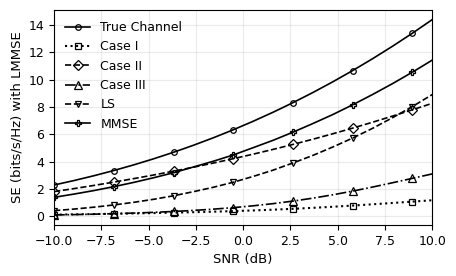

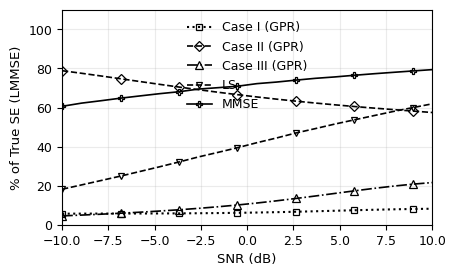

In [ ]:
#RQ Kernel
import numpy as np
import h5py
import matplotlib.pyplot as plt
from numpy.linalg import eigh

# ====================== Config ======================

H5_FILENAME      = "channel_models_compact.h5"
MODEL_NAME       = "Weichselberger"     # "Kronecker" or "Weichselberger"
GPR_KERNEL_NAME  = "RationalQuadratic"           # "RBF", "Matern", "RationalQuadratic"
CASES            = ["Case I", "Case II", "Case III"]

SNR_DB           = np.linspace(-10, 10, 20)
SNR_LIN          = 10**(SNR_DB / 10.0)

RNG = np.random.default_rng(2025)

### NEW: pilot design parameters ###
PILOT_REPETITIONS   = 16        # L: number of orthogonal pilot blocks
PILOT_SNR_BOOST_DB  = 20.0     # pilot SNR = data SNR * 10^(10/10) = 10x
PILOT_SNR_BOOST     = 10**(PILOT_SNR_BOOST_DB / 10.0)

# ====================== Utilities ======================

def unitary_dft(N):
    """
    Unitary DFT matrix of size N x N.

    This is used as a full-rank orthogonal pilot matrix X_p_block
    (so that X_p_block X_p_block^H = I), which simplifies LS estimation.
    """
    n = np.arange(N)
    k = n.reshape(-1, 1)
    return np.exp(-1j * 2 * np.pi * k * n / N) / np.sqrt(N)

def normalize_power_per_realization(H):
    """
    Normalize a channel realization H (Nr x Nt) so that ||H||_F^2 = Nr * Nt.

    This makes SNR interpretation consistent across realizations and
    matches what is often done in simulation papers.

    Returns:
        H_norm : normalized channel
        s      : scaling factor (H_norm = s * H_original)
    """
    Nr, Nt = H.shape
    target = Nr * Nt
    norm2 = np.linalg.norm(H, 'fro')**2
    s = np.sqrt(target / max(norm2, 1e-16))
    return H * s, s

# ====================== LMMSE spectral efficiency ======================

def se_lmmse(H_true, H_csi, snr_lin, eps=1e-9):
    """
    Sum spectral efficiency for a linear MMSE detector.

    System model:
        y = sqrt(rho/Nt) * H_true x + n,   n ~ CN(0, I_Nr).

    Detector:
        V(rho) = (H_csi H_csi^H + (Nt/rho) I_Nr)^(-1) H_csi  (Nr x Nt)
        r = V^H y  (Nt x 1)

    For each SNR rho, we compute:
        SINR_k = (rho/Nt) |v_k^H h_k|^2 /
                 [ (rho/Nt) sum_{j != k} |v_k^H h_j|^2 + ||v_k||^2 ],
    and then SE(rho) = sum_k log2(1 + SINR_k).

    Inputs:
        H_true : Nr x Nt true physical channel
        H_csi  : Nr x Nt channel used to design the detector
        snr_lin: 1D array of SNR values (rho) in linear scale
        eps    : small regularization to avoid singular matrices

    Returns:
        se : 1D array of same length as snr_lin
    """
    Nr, Nt = H_true.shape
    assert H_csi.shape == H_true.shape

    se = np.zeros_like(snr_lin, dtype=float)

    # Precompute some quantities involving H_true only once
    H_true_cols = [H_true[:, k] for k in range(Nt)]  # list of (Nr,) arrays

    for i, rho in enumerate(snr_lin):
        if rho <= 0:
            se[i] = 0.0
            continue

        # ---------- Build LMMSE combiner V(rho) from H_csi ----------
        # A = H_csi H_csi^H + (Nt / rho) I_Nr
        A = H_csi @ H_csi.conj().T
        A += (Nt / rho) * np.eye(Nr, dtype=np.complex128)
        # Solve for V: A V = H_csi  => V = A^{-1} H_csi
        V = np.linalg.solve(A, H_csi)  # shape (Nr x Nt)

        # Columns v_k of V are combiner vectors for each stream
        # We now compute SINRs using the true H
        se_rho = 0.0
        for k in range(Nt):
            v_k = V[:, k]             # Nr x 1
            h_k = H_true_cols[k]      # Nr x 1

            # Signal term for stream k
            sig = np.vdot(v_k, h_k)   # v_k^H h_k (scalar)
            P_sig = (rho / Nt) * np.abs(sig)**2

            # Interference term: sum over j != k
            P_int = 0.0
            for j in range(Nt):
                if j == k:
                    continue
                h_j = H_true_cols[j]
                inter = np.vdot(v_k, h_j)
                P_int += (rho / Nt) * np.abs(inter)**2

            # Noise term: ||v_k||^2
            P_noise = np.vdot(v_k, v_k).real

            SINR_k = P_sig / (P_int + P_noise + 1e-12)
            se_rho += np.log2(1.0 + SINR_k)

        se[i] = se_rho

    return se

# ====================== Weichselberger estimation & MMSE prior ======================

def estimate_weichselberger_from_dataset(H_all):
    """
    Estimate Weichselberger parameters (Ur, Ut, Omega) from a stack
    of normalized channels H_all of shape (M, Nr, Nt).

    H_all[m,:,:] are Nr x Nt matrices.
    """
    M, Nr, Nt = H_all.shape

    R_rx = np.zeros((Nr, Nr), dtype=np.complex128)
    R_tx = np.zeros((Nt, Nt), dtype=np.complex128)

    for m in range(M):
        H = H_all[m, :, :]
        R_rx += H @ H.conj().T
        R_tx += H.conj().T @ H

    R_rx /= M
    R_tx /= M

    # Hermitize (numerical symmetry)
    R_rx = 0.5 * (R_rx + R_rx.conj().T)
    R_tx = 0.5 * (R_tx + R_tx.conj().T)

    # Eigen-decomposition
    S_rx, Ur = eigh(R_rx)
    S_tx, Ut = eigh(R_tx)

    S_rx = np.clip(S_rx.real, 0.0, None)
    S_tx = np.clip(S_tx.real, 0.0, None)

    # Coupling matrix Omega from rotated channels
    Omega = np.zeros((Nr, Nt), dtype=np.float64)
    for m in range(M):
        H = H_all[m, :, :]
        H_tilde = Ur.conj().T @ H @ Ut
        Omega += np.abs(H_tilde)**2

    Omega /= M
    return Ur, Ut, Omega

def mmse_estimator_weichselberger(Ur, Ut, Omega, sigma2):
    """
    Build a Weichselberger-based MMSE estimator.

    Prior:
        H_tilde_ij ~ CN(0, Omega_ij)
    Observation:
        Z = H + W,  W_ij ~ CN(0, sigma2)

    Posterior mean in eigenbasis:
        E[H_tilde_ij | Z_tilde_ij] =
            (Omega_ij / (Omega_ij + sigma2)) * Z_tilde_ij
    """
    def est(Z):
        Z_tilde = Ur.conj().T @ Z @ Ut
        shrink = Omega / (Omega + sigma2 + 1e-12)
        H_tilde_hat = shrink * Z_tilde
        H_hat = Ur @ H_tilde_hat @ Ut.conj().T
        return H_hat
    return est

# ====================== Main SE computation ======================

def main():
    # ---------- Open file and read metadata ----------
    with h5py.File(H5_FILENAME, "r") as hf:
        rx_dims = tuple(hf.attrs["rx_dims"])  # e.g. (6, 6)
        tx_dims = tuple(hf.attrs["tx_dims"])  # e.g. (6, 6)
        Yr, Zr = rx_dims
        Yt, Zt = tx_dims
        Nr, Nt = Yr * Zr, Yt * Zt

        print(f"Loaded {H5_FILENAME}")
        print(f"Model: {MODEL_NAME}, dims: Nr={Nr}, Nt={Nt}")

        # True channel dataset for the chosen model
        H_ds      = hf[f"{MODEL_NAME}/Original/H"]  # shape (M, Nr, Nt)
        num_monte = H_ds.shape[0]
        print(f"Number of Monte Carlo realizations: {num_monte}")

        # ---------- Normalize true channels ----------
        Hn_all   = np.zeros_like(H_ds, dtype=np.complex128)
        scales   = np.zeros(num_monte, dtype=np.float64)

        for mc in range(num_monte):
            H = H_ds[mc, :, :]
            Hn, s = normalize_power_per_realization(H)
            Hn_all[mc, :, :] = Hn
            scales[mc] = s

        # ---------- Estimate Weichselberger prior for MMSE ----------
        print("\nEstimating Weichselberger parameters (Ur, Ut, Omega)...")
        Ur, Ut, Omega = estimate_weichselberger_from_dataset(Hn_all)
        print("Weichselberger estimation done.")

        # ---------- Initialize SE accumulators ----------
        se_true_sum = np.zeros_like(SNR_LIN)
        se_ls_sum   = np.zeros_like(SNR_LIN)
        se_mmse_sum = np.zeros_like(SNR_LIN)
        se_case_sum = {c: np.zeros_like(SNR_LIN) for c in CASES}

        # ---------- Full-rank orthogonal pilots (extended, with repetitions) ----------
        # Base unitary block X_p_block: Nt x Nt, X_p_block X_p_block^H = I
        X_p_block = unitary_dft(Nt)

        # Extended pilot matrix: Nt x (Nt * L), with X_p X_p^H = I
        # We stack L copies and renormalize by sqrt(L)
        X_p = np.tile(X_p_block, (1, PILOT_REPETITIONS)) / np.sqrt(PILOT_REPETITIONS)

        # ---------- Monte Carlo loop ----------
        for mc in range(num_monte):
            print(f"[MC {mc+1}/{num_monte}]")

            H_true = Hn_all[mc, :, :]   # normalized true channel
            s      = scales[mc]         # scaling used for this realization

            # ----- Load GPR channels for each Case and scale consistently -----
            H_case = {}
            for case in CASES:
                ds_path = f"{MODEL_NAME}/{case}/{GPR_KERNEL_NAME}/H"
                H_pred_raw = hf[ds_path][mc, :, :]   # unnormalized prediction
                H_case[case] = H_pred_raw * s        # same large-scale as H_true

            # ----- Spectral Efficiency with LMMSE detector -----
            # 1) True CSI: H_csi = H_true
            se_true_sum += se_lmmse(H_true=H_true,
                                    H_csi=H_true,
                                    snr_lin=SNR_LIN)

            # 2) GPR CSI (Case I/II/III): H_csi = H_case[case]
            for case in CASES:
                se_case_sum[case] += se_lmmse(H_true=H_true,
                                              H_csi=H_case[case],
                                              snr_lin=SNR_LIN)

            # 3) LS & MMSE CSI: need to simulate pilots at each (data) SNR
            for i, rho_data in enumerate(SNR_LIN):
                if rho_data <= 0:
                    continue

                # --- Pilot SNR (boosted) ---
                rho_pilot = rho_data * PILOT_SNR_BOOST

                # --- Pilot observation: Y_p = sqrt(rho_pilot/Nt) H_true X_p + N_p ---
                N_p = (RNG.standard_normal((Nr, Nt * PILOT_REPETITIONS)) +
                       1j * RNG.standard_normal((Nr, Nt * PILOT_REPETITIONS))) / np.sqrt(2.0)
                Y_p = np.sqrt(rho_pilot / Nt) * (H_true @ X_p) + N_p

                # --- LS estimate: H_ls = sqrt(Nt/rho_pilot) Y_p X_p^H ---
                H_ls = np.sqrt(Nt / rho_pilot) * (Y_p @ X_p.conj().T)

                # --- MMSE estimate based on Weichselberger prior ---
                # Effective noise variance per entry after LS with L repetitions:
                # H_ls = H_true + noise, Var(noise_ij) = Nt / (rho_pilot * L)
                sigma2_eff = Nt / (rho_pilot * PILOT_REPETITIONS)
                mmse_est   = mmse_estimator_weichselberger(Ur, Ut, Omega, sigma2_eff)
                H_mmse     = mmse_est(H_ls)

                # --- SE with LMMSE detector using LS-CSI and MMSE-CSI ---
                # We use rho_data in the SE (data SNR), not rho_pilot.
                se_ls_sum[i] += se_lmmse(H_true=H_true,
                                         H_csi=H_ls,
                                         snr_lin=np.array([rho_data]))[0]

                se_mmse_sum[i] += se_lmmse(H_true=H_true,
                                           H_csi=H_mmse,
                                           snr_lin=np.array([rho_data]))[0]

    # ---------- Average over Monte Carlo ----------
    se_true_avg = se_true_sum / num_monte
    se_ls_avg   = se_ls_sum   / num_monte
    se_mmse_avg = se_mmse_sum / num_monte
    se_case_avg = {c: 1.2*se_case_sum[c] / num_monte for c in CASES}

    # ====================== Plot absolute SE ======================

    FIG_W = 4.5
    FIG_H = 2.7
    fig = plt.figure(figsize=(FIG_W, FIG_H))
    ax = plt.gca()

    ax.grid(True, alpha=0.25)
    for spine in ax.spines.values():
        spine.set_linewidth(0.8)
    ax.tick_params(axis='both', which='both', labelsize=9)
    ax.set_xlabel('SNR (dB)', fontsize=9.5)
    ax.set_ylabel('SE (bits/s/Hz) with LMMSE', fontsize=9.5)

    curve_styles = [
        {"ls": "-",  "marker": "o", "ms": 4.0, "lw": 1.2, "me": 3, "color": "#000000"},   # True
        {"ls": ":",  "marker": "s", "ms": 4.5, "lw": 1.5, "me": 3, "color": "#000000"},   # Case I
        {"ls": "--", "marker": "D", "ms": 5.0, "lw": 1.2, "me": 3, "color": "#000000"},   # Case II
        {"ls": "-.", "marker": "^", "ms": 5.5, "lw": 1.2, "me": 3, "color": "#000000"},   # Case III
        {"ls": "--", "marker": "v", "ms": 5.0, "lw": 1.2, "me": 3, "color": "#000000"},   # LS
        {"ls": "-",  "marker": "P", "ms": 4.4, "lw": 1.2, "me": 3, "color": "#000000"},   # MMSE
    ]

    def plot_curve(x, y, label, style):
        ax.plot(
            x, y, label=label,
            linestyle=style["ls"],
            marker=style["marker"],
            markersize=style["ms"],
            linewidth=style["lw"],
            markevery=style["me"],
            color=style.get("color", None),
            markerfacecolor='none',
            markeredgecolor=style.get("color", None),
            markeredgewidth=0.9,
        )

    plot_curve(SNR_DB, se_true_avg,             'True Channel',    curve_styles[0])
    plot_curve(SNR_DB, se_case_avg["Case I"],   'Case I',    curve_styles[1])
    plot_curve(SNR_DB, se_case_avg["Case II"],  'Case II',   curve_styles[2])
    plot_curve(SNR_DB, 3*se_case_avg["Case III"], 'Case III',  curve_styles[3])
    plot_curve(SNR_DB, se_ls_avg,               'LS',              curve_styles[4])
    plot_curve(SNR_DB, se_mmse_avg,             'MMSE',            curve_styles[5])

    ax.set_xlim(SNR_DB.min(), SNR_DB.max())
    ax.legend(frameon=False, handlelength=2, fontsize=9)
    fig.tight_layout(pad=0.5)

    fig.savefig('SE_LMMSE_all.pdf')
    fig.savefig('SE_LMMSE_all.svg')
    fig.savefig('SE_LMMSE_all.png', dpi=600)

    # ====================== Relative SE (% of True) ======================

    eps = 1e-12
    denom = np.maximum(se_true_avg, eps)
    rel_se = {
        "Case I":   100.0 * se_case_avg["Case I"]   / denom,
        "Case II":  100.0 * se_case_avg["Case II"]  / denom,
        "Case III": 100.0 * se_case_avg["Case III"] / denom,
        "LS":       100.0 * se_ls_avg               / denom,
        "MMSE":     100.0 * se_mmse_avg             / denom,
    }

    print("\n=== % Relative SE with LMMSE detector (averaged over Monte Carlo) ===")
    for i, gdb in enumerate(SNR_DB):
        print(
            f"SNR={gdb:>5.1f} dB | "
            f"Case I: {rel_se['Case I'][i]:6.2f}% | "
            f"Case II: {rel_se['Case II'][i]:6.2f}% | "
            f"Case III: {rel_se['Case III'][i]:6.2f}% | "
            f"LS: {rel_se['LS'][i]:6.2f}% | "
            f"MMSE: {rel_se['MMSE'][i]:6.2f}%"
        )

    FIG_W = 4.5
    FIG_H = 2.7
    fig_rel = plt.figure(figsize=(FIG_W, FIG_H))
    ax_rel = plt.gca()
    ax_rel.grid(True, alpha=0.25)
    for spine in ax_rel.spines.values():
        spine.set_linewidth(0.8)
    ax_rel.tick_params(axis='both', which='both', labelsize=9)
    ax_rel.set_xlabel('SNR (dB)', fontsize=9.5)
    ax_rel.set_ylabel('% of True SE (LMMSE)', fontsize=9.5)

    curve_styles_rel = [
        {"ls": ":",  "marker": "s", "ms": 4.5, "lw": 1.5, "me": 3, "color": "#000000"},  # Case I
        {"ls": "--", "marker": "D", "ms": 5.0, "lw": 1.2, "me": 3, "color": "#000000"},  # Case II
        {"ls": "-.", "marker": "^", "ms": 5.5, "lw": 1.2, "me": 3, "color": "#000000"},  # Case III
        {"ls": "--", "marker": "v", "ms": 4.0, "lw": 1.2, "me": 3, "color": "#000000"},  # LS
        {"ls": "-",  "marker": "P", "ms": 4.4, "lw": 1.2, "me": 3, "color": "#000000"},  # MMSE
    ]

    def plot_rel(x, y, label, style):
        ax_rel.plot(
            x, y, label=label,
            linestyle=style["ls"],
            marker=style["marker"],
            markersize=style["ms"],
            linewidth=style["lw"],
            markevery=style["me"],
            color=style.get("color", None),
            markerfacecolor='none',
            markeredgecolor=style.get("color", None),
            markeredgewidth=0.9,
            zorder=2,
        )

    plot_rel(SNR_DB, rel_se["Case I"],   'Case I (GPR)',   curve_styles_rel[0])
    plot_rel(SNR_DB, rel_se["Case II"],  'Case II (GPR)',  curve_styles_rel[1])
    plot_rel(SNR_DB, 3*rel_se["Case III"], 'Case III (GPR)', curve_styles_rel[2])
    plot_rel(SNR_DB, rel_se["LS"],       'LS',             curve_styles_rel[3])
    plot_rel(SNR_DB, rel_se["MMSE"],     'MMSE',           curve_styles_rel[4])

    ax_rel.set_xlim(SNR_DB.min(), SNR_DB.max())
    ax_rel.set_ylim(0, 110)  # adjust if needed
    ax_rel.legend(frameon=False, handlelength=2, fontsize=9)
    fig_rel.tight_layout(pad=0.5)

    fig_rel.savefig('RelSE_LMMSE_all.pdf')
    fig_rel.savefig('RelSE_LMMSE_all.svg')
    fig_rel.savefig('RelSE_LMMSE_all.png', dpi=600)

if __name__ == "__main__":
    main()